In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/UROLOGÍA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=179.2, y1=102.1
Page 1, Q1, A: Yellow pixels: 174
Page 1, Q1, A: Total non-white pixels: 715
Page 1, Q1, A: Yellow percentage: 24.3%


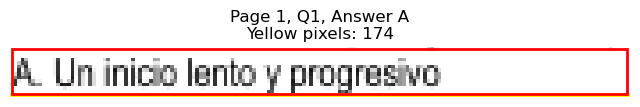

Page 1, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=268.4, y1=114.7
Page 1, Q1, B: Yellow pixels: 2615
Page 1, Q1, B: Total non-white pixels: 3419
Page 1, Q1, B: Yellow percentage: 76.5%


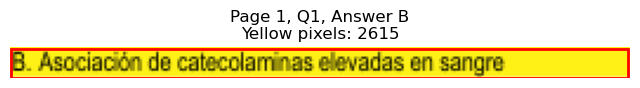

Page 1, Q1 - C: Detected box: x0=56.6, y0=114.6, x1=409.3, y1=127.3
Page 1, Q1, C: Yellow pixels: 402
Page 1, Q1, C: Total non-white pixels: 2119
Page 1, Q1, C: Yellow percentage: 19.0%


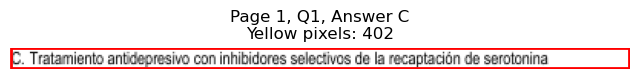

Page 1, Q1 - D: Detected box: x0=56.6, y0=127.2, x1=222.3, y1=139.9
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 793
Page 1, Q1, D: Yellow percentage: 0.0%


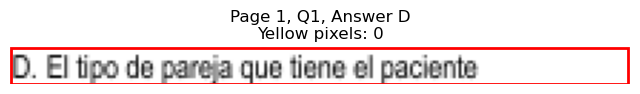


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)
Page 1, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=208.1, y1=190.4
Page 1, Q2, A: Yellow pixels: 203
Page 1, Q2, A: Total non-white pixels: 965
Page 1, Q2, A: Yellow percentage: 21.0%


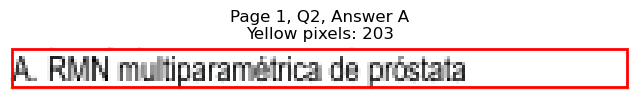

Page 1, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=201.8, y1=203.0
Page 1, Q2, B: Yellow pixels: 1963
Page 1, Q2, B: Total non-white pixels: 2548
Page 1, Q2, B: Yellow percentage: 77.0%


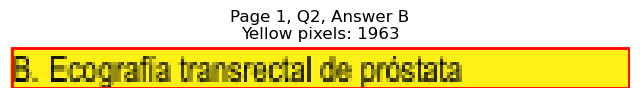

Page 1, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=380.2, y1=190.4
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 286
Page 1, Q2, C: Yellow percentage: 0.0%


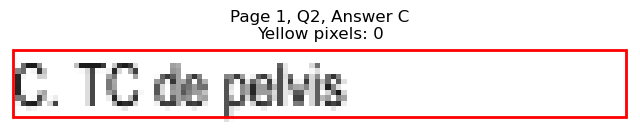

Page 1, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=480.6, y1=203.0
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 832
Page 1, Q2, D: Yellow percentage: 0.0%


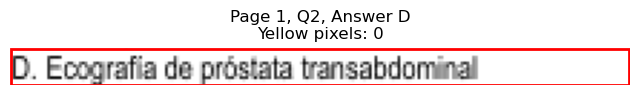


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)
Page 1, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=186.6, y1=253.5
Page 1, Q3, A: Yellow pixels: 1880
Page 1, Q3, A: Total non-white pixels: 2534
Page 1, Q3, A: Yellow percentage: 74.2%


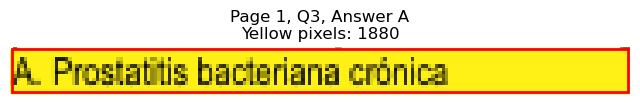

Page 1, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=89.4, y1=266.1
Page 1, Q3, B: Yellow pixels: 84
Page 1, Q3, B: Total non-white pixels: 234
Page 1, Q3, B: Yellow percentage: 35.9%


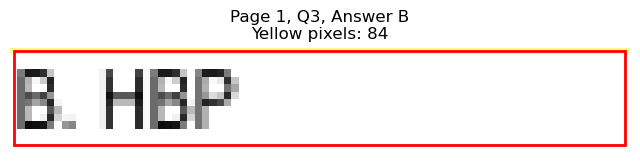

Page 1, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=398.2, y1=253.5
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 402
Page 1, Q3, C: Yellow percentage: 0.0%


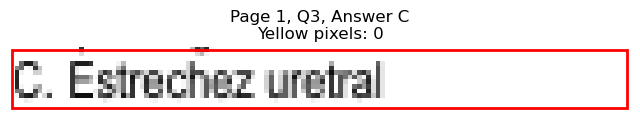

Page 1, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=409.3, y1=266.1
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 438
Page 1, Q3, D: Yellow percentage: 0.0%


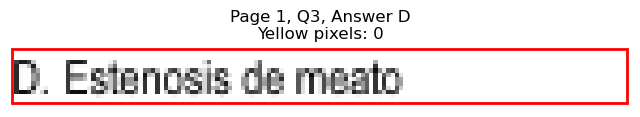


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)
Page 1, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=118.0, y1=316.6
Page 1, Q4, A: Yellow pixels: 1243
Page 1, Q4, A: Total non-white pixels: 1460
Page 1, Q4, A: Yellow percentage: 85.1%


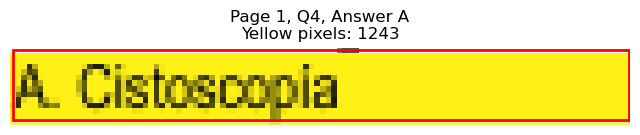

Page 1, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=116.9, y1=329.2
Page 1, Q4, B: Yellow pixels: 111
Page 1, Q4, B: Total non-white pixels: 390
Page 1, Q4, B: Yellow percentage: 28.5%


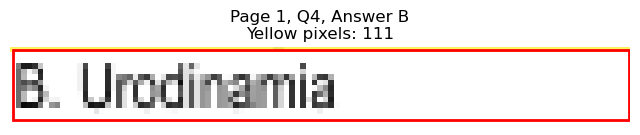

Page 1, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=447.9, y1=316.6
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 657
Page 1, Q4, C: Yellow percentage: 0.0%


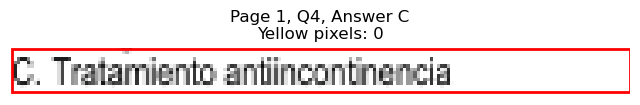

Page 1, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=383.7, y1=329.2
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 324
Page 1, Q4, D: Yellow percentage: 0.0%


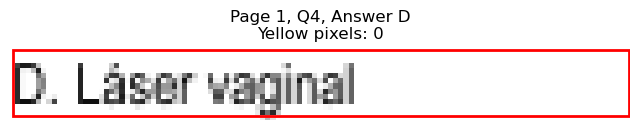


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)
Page 1, Q5 - A: Detected box: x0=56.6, y0=392.3, x1=183.1, y1=405.0
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 660
Page 1, Q5, A: Yellow percentage: 0.0%


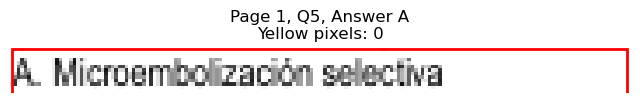

Page 1, Q5 - B: Detected box: x0=56.6, y0=404.9, x1=174.6, y1=417.6
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 579
Page 1, Q5, B: Yellow percentage: 0.0%


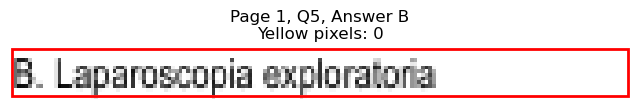

Page 1, Q5 - C: Detected box: x0=315.4, y0=392.3, x1=380.2, y1=405.0
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 376
Page 1, Q5, C: Yellow percentage: 0.0%


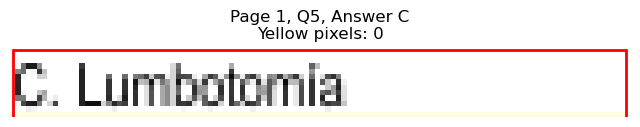

Page 1, Q5 - D: Detected box: x0=315.4, y0=404.9, x1=394.7, y1=417.6
Page 1, Q5, D: Yellow pixels: 1416
Page 1, Q5, D: Total non-white pixels: 1820
Page 1, Q5, D: Yellow percentage: 77.8%


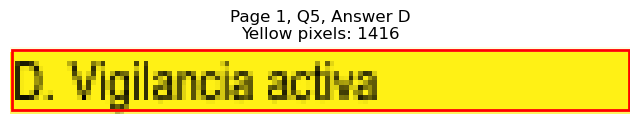


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)
Page 1, Q6 - A: Detected box: x0=56.6, y0=455.5, x1=153.6, y1=468.1
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 483
Page 1, Q6, A: Yellow percentage: 0.0%


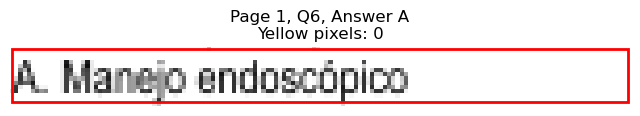

Page 1, Q6 - B: Detected box: x0=56.6, y0=468.1, x1=141.5, y1=480.7
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 423
Page 1, Q6, B: Yellow percentage: 0.0%


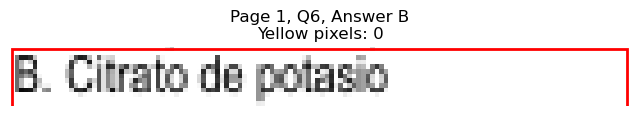

Page 1, Q6 - C: Detected box: x0=315.4, y0=455.5, x1=479.1, y1=468.1
Page 1, Q6, C: Yellow pixels: 2166
Page 1, Q6, C: Total non-white pixels: 3010
Page 1, Q6, C: Yellow percentage: 72.0%


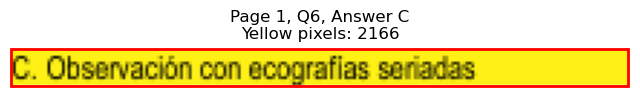

Page 1, Q6 - D: Detected box: x0=315.4, y0=468.1, x1=474.6, y1=480.7
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 1007
Page 1, Q6, D: Yellow percentage: 0.0%


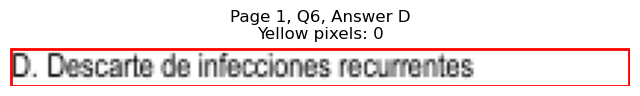


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)
Page 1, Q7 - A: Detected box: x0=56.6, y0=506.0, x1=88.8, y1=518.6
Page 1, Q7, A: Yellow pixels: 981
Page 1, Q7, A: Total non-white pixels: 1162
Page 1, Q7, A: Yellow percentage: 84.4%


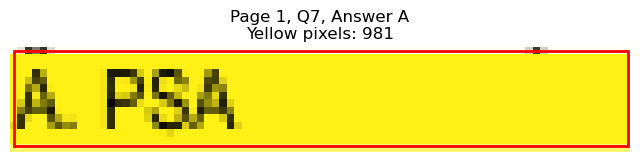

Page 1, Q7 - B: Detected box: x0=56.6, y0=518.6, x1=139.0, y1=531.2
Page 1, Q7, B: Yellow pixels: 133
Page 1, Q7, B: Total non-white pixels: 558
Page 1, Q7, B: Yellow percentage: 23.8%


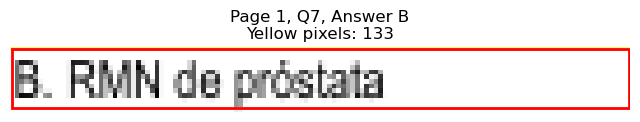

Page 1, Q7 - C: Detected box: x0=315.4, y0=506.0, x1=388.7, y1=518.6
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 318
Page 1, Q7, C: Yellow percentage: 0.0%


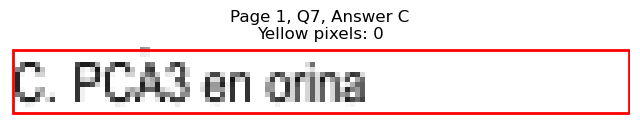

Page 1, Q7 - D: Detected box: x0=315.4, y0=518.6, x1=402.8, y1=531.2
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 435
Page 1, Q7, D: Yellow percentage: 0.0%


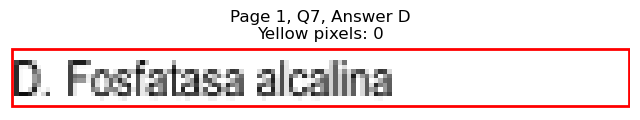


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)
Page 1, Q8 - A: Detected box: x0=56.6, y0=556.5, x1=88.9, y1=569.1
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 102
Page 1, Q8, A: Yellow percentage: 0.0%


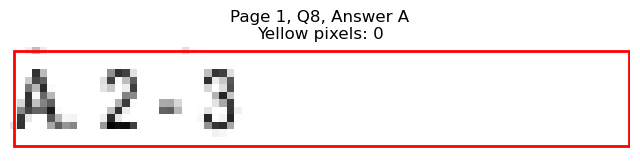

Page 1, Q8 - B: Detected box: x0=56.6, y0=569.1, x1=94.0, y1=581.7
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 124
Page 1, Q8, B: Yellow percentage: 0.0%


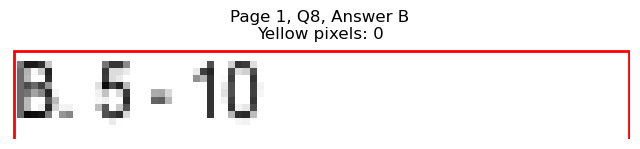

Page 1, Q8 - C: Detected box: x0=315.4, y0=556.5, x1=347.9, y1=569.1
Page 1, Q8, C: Yellow pixels: 83
Page 1, Q8, C: Total non-white pixels: 189
Page 1, Q8, C: Yellow percentage: 43.9%


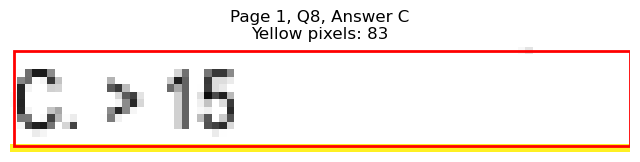

Page 1, Q8 - D: Detected box: x0=315.4, y0=569.1, x1=342.9, y1=581.7
Page 1, Q8, D: Yellow pixels: 953
Page 1, Q8, D: Total non-white pixels: 1014
Page 1, Q8, D: Yellow percentage: 94.0%


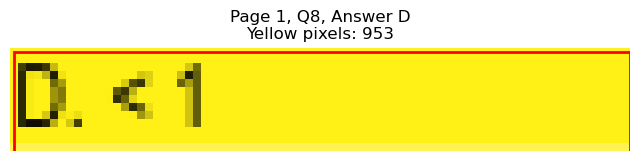


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)
Page 1, Q9 - A: Detected box: x0=56.6, y0=606.9, x1=126.5, y1=619.5
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 311
Page 1, Q9, A: Yellow percentage: 0.0%


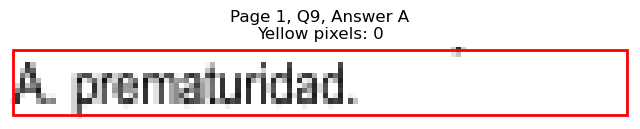

Page 1, Q9 - B: Detected box: x0=56.6, y0=619.6, x1=157.1, y1=632.3
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 507
Page 1, Q9, B: Yellow percentage: 0.0%


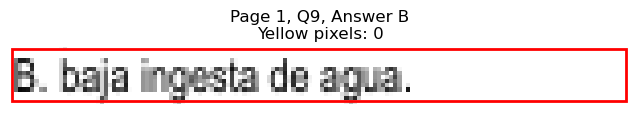

Page 1, Q9 - C: Detected box: x0=315.4, y0=606.9, x1=360.7, y1=619.5
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 201
Page 1, Q9, C: Yellow percentage: 0.0%


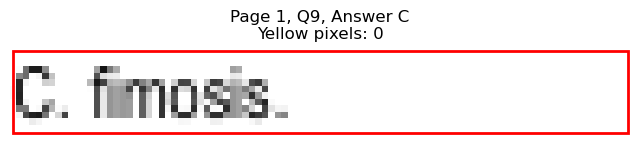

Page 1, Q9 - D: Detected box: x0=315.4, y0=619.6, x1=455.9, y1=632.3
Page 1, Q9, D: Yellow pixels: 1780
Page 1, Q9, D: Total non-white pixels: 2674
Page 1, Q9, D: Yellow percentage: 66.6%


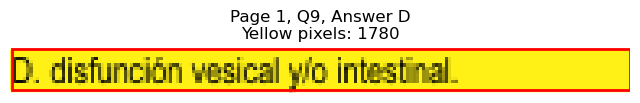


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)
Page 1, Q10 - A: Detected box: x0=56.6, y0=657.4, x1=137.1, y1=670.1
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 378
Page 1, Q10, A: Yellow percentage: 0.0%


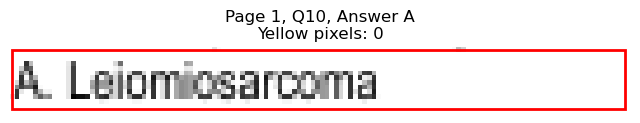

Page 1, Q10 - B: Detected box: x0=56.6, y0=670.0, x1=139.0, y1=682.7
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 402
Page 1, Q10, B: Yellow percentage: 0.0%


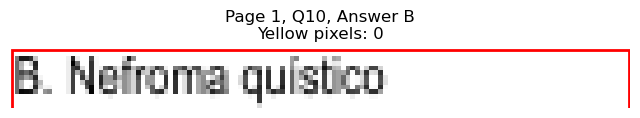

Page 1, Q10 - C: Detected box: x0=315.4, y0=657.4, x1=448.9, y1=670.1
Page 1, Q10, C: Yellow pixels: 1925
Page 1, Q10, C: Total non-white pixels: 2576
Page 1, Q10, C: Yellow percentage: 74.7%


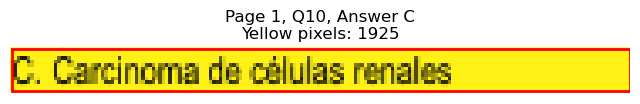

Page 1, Q10 - D: Detected box: x0=315.4, y0=670.0, x1=464.9, y1=682.7
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 917
Page 1, Q10, D: Yellow percentage: 0.0%


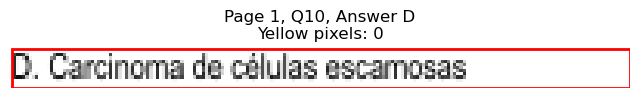


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)
Page 1, Q11 - A: Detected box: x0=56.6, y0=240.8, x1=110.5, y1=253.5
Page 1, Q11, A: Yellow pixels: 979
Page 1, Q11, A: Total non-white pixels: 1470
Page 1, Q11, A: Yellow percentage: 66.6%


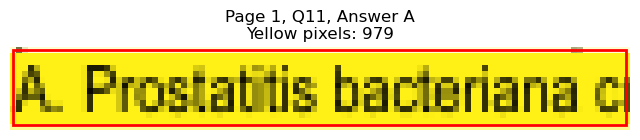

Page 1, Q11 - B: Detected box: x0=56.6, y0=720.6, x1=142.6, y1=733.2
Page 1, Q11, B: Yellow pixels: 0
Page 1, Q11, B: Total non-white pixels: 421
Page 1, Q11, B: Yellow percentage: 0.0%


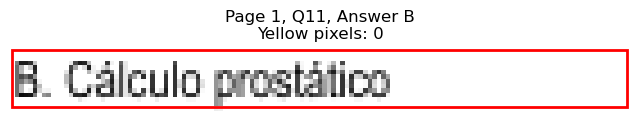

Page 1, Q11 - C: Detected box: x0=315.4, y0=708.0, x1=397.7, y1=720.6
Page 1, Q11, C: Yellow pixels: 133
Page 1, Q11, C: Total non-white pixels: 533
Page 1, Q11, C: Yellow percentage: 25.0%


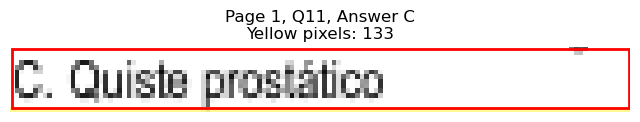

Page 1, Q11 - D: Detected box: x0=315.4, y0=720.6, x1=442.9, y1=733.2
Page 1, Q11, D: Yellow pixels: 1841
Page 1, Q11, D: Total non-white pixels: 2492
Page 1, Q11, D: Yellow percentage: 73.9%


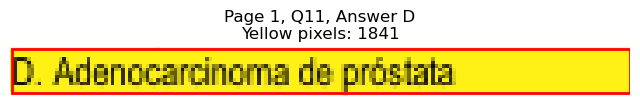


Page 1, Q11 - Selected Answer: D (based on yellow pixel count)

Page 2: Found 12 questions
Page 2, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=124.9, y1=114.7
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 405
Page 2, Q1, A: Yellow percentage: 0.0%


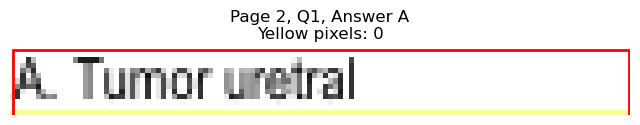

Page 2, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=128.5, y1=127.3
Page 2, Q1, B: Yellow pixels: 1200
Page 2, Q1, B: Total non-white pixels: 1722
Page 2, Q1, B: Yellow percentage: 69.7%


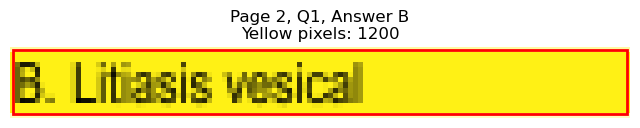

Page 2, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=399.8, y1=114.7
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 388
Page 2, Q1, C: Yellow percentage: 0.0%


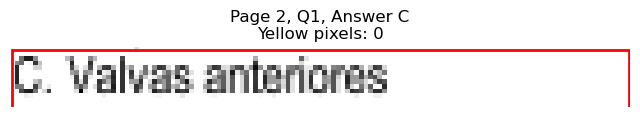

Page 2, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=397.3, y1=127.3
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 403
Page 2, Q1, D: Yellow percentage: 0.0%


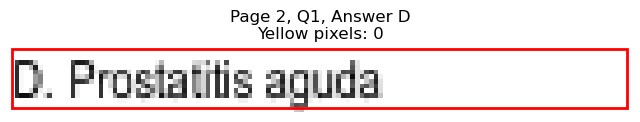


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)
Page 2, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=109.9, y1=165.2
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 256
Page 2, Q2, A: Yellow percentage: 0.0%


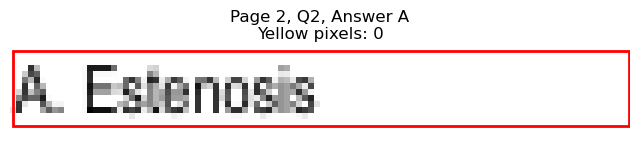

Page 2, Q2 - B: Detected box: x0=56.6, y0=165.1, x1=116.9, y1=177.8
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 277
Page 2, Q2, B: Yellow percentage: 0.0%


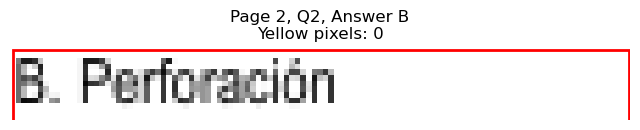

Page 2, Q2 - C: Detected box: x0=315.4, y0=152.5, x1=364.1, y1=165.2
Page 2, Q2, C: Yellow pixels: 1131
Page 2, Q2, C: Total non-white pixels: 1400
Page 2, Q2, C: Yellow percentage: 80.8%


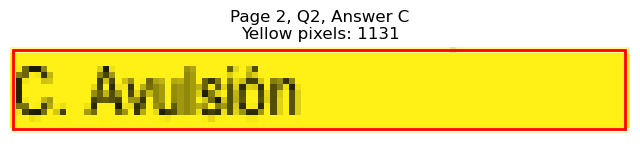

Page 2, Q2 - D: Detected box: x0=315.4, y0=165.1, x1=441.4, y1=177.8
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 786
Page 2, Q2, D: Yellow percentage: 0.0%


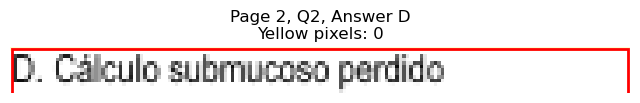


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)
Page 2, Q3 - A: Detected box: x0=56.6, y0=202.9, x1=122.9, y1=215.6
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 309
Page 2, Q3, A: Yellow percentage: 0.0%


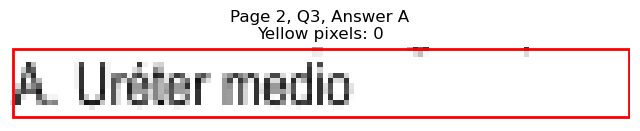

Page 2, Q3 - B: Detected box: x0=56.6, y0=215.6, x1=146.5, y1=228.3
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 428
Page 2, Q3, B: Yellow percentage: 0.0%


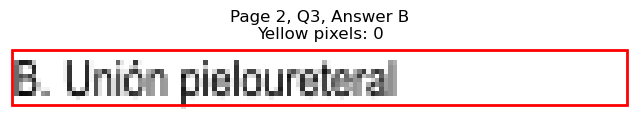

Page 2, Q3 - C: Detected box: x0=315.4, y0=202.9, x1=412.3, y1=215.6
Page 2, Q3, C: Yellow pixels: 1552
Page 2, Q3, C: Total non-white pixels: 2072
Page 2, Q3, C: Yellow percentage: 74.9%


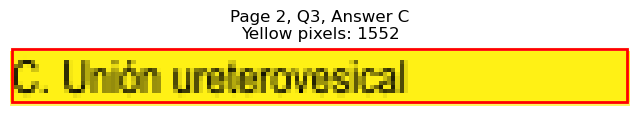

Page 2, Q3 - D: Detected box: x0=315.4, y0=215.6, x1=486.0, y1=228.3
Page 2, Q3, D: Yellow pixels: 221
Page 2, Q3, D: Total non-white pixels: 1035
Page 2, Q3, D: Yellow percentage: 21.4%


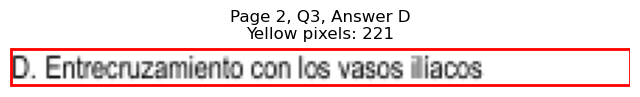


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)
Page 2, Q4 - A: Detected box: x0=56.6, y0=253.4, x1=121.5, y1=266.1
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 285
Page 2, Q4, A: Yellow percentage: 0.0%


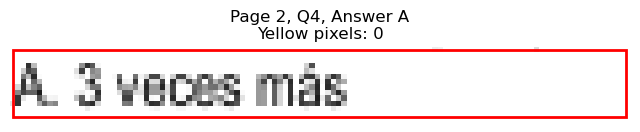

Page 2, Q4 - B: Detected box: x0=56.6, y0=266.0, x1=121.6, y1=278.7
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 285
Page 2, Q4, B: Yellow percentage: 0.0%


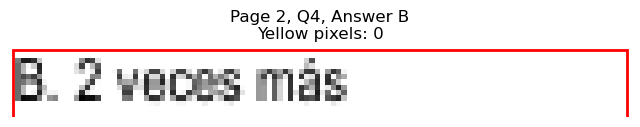

Page 2, Q4 - C: Detected box: x0=315.4, y0=253.4, x1=395.8, y1=266.1
Page 2, Q4, C: Yellow pixels: 1437
Page 2, Q4, C: Total non-white pixels: 1834
Page 2, Q4, C: Yellow percentage: 78.4%


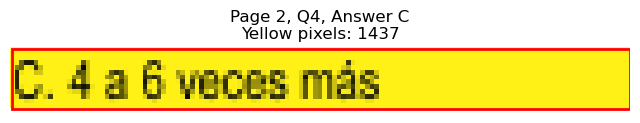

Page 2, Q4 - D: Detected box: x0=315.4, y0=266.0, x1=367.7, y1=278.7
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 337
Page 2, Q4, D: Yellow percentage: 0.0%


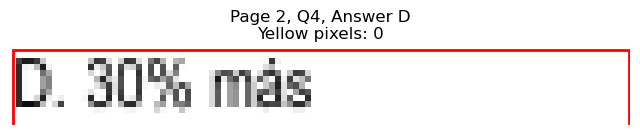


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)
Page 2, Q5 - A: Detected box: x0=56.6, y0=316.6, x1=205.7, y1=329.2
Page 2, Q5, A: Yellow pixels: 200
Page 2, Q5, A: Total non-white pixels: 852
Page 2, Q5, A: Yellow percentage: 23.5%


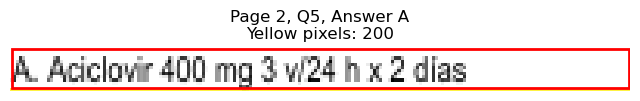

Page 2, Q5 - B: Detected box: x0=56.6, y0=329.2, x1=203.2, y1=341.8
Page 2, Q5, B: Yellow pixels: 2066
Page 2, Q5, B: Total non-white pixels: 2574
Page 2, Q5, B: Yellow percentage: 80.3%


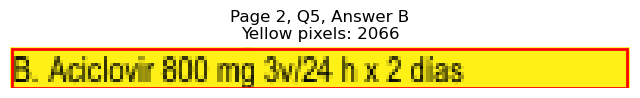

Page 2, Q5 - C: Detected box: x0=315.4, y0=316.6, x1=457.0, y1=329.2
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 626
Page 2, Q5, C: Yellow percentage: 0.0%


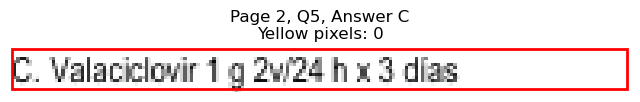

Page 2, Q5 - D: Detected box: x0=315.4, y0=329.2, x1=457.0, y1=341.8
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 622
Page 2, Q5, D: Yellow percentage: 0.0%


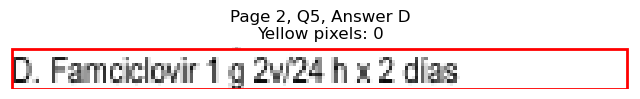


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)
Page 2, Q6 - A: Detected box: x0=56.6, y0=367.1, x1=269.9, y1=379.8
Page 2, Q6, A: Yellow pixels: 2
Page 2, Q6, A: Total non-white pixels: 1259
Page 2, Q6, A: Yellow percentage: 0.2%


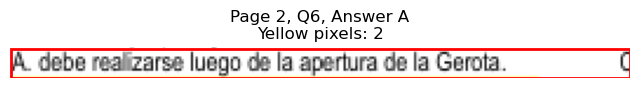

Page 2, Q6 - B: Detected box: x0=56.6, y0=379.7, x1=213.3, y1=392.4
Page 2, Q6, B: Yellow pixels: 1887
Page 2, Q6, B: Total non-white pixels: 2912
Page 2, Q6, B: Yellow percentage: 64.8%


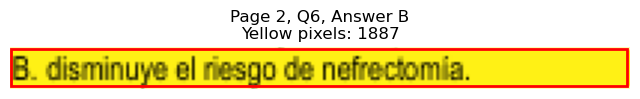

Page 2, Q6 - C: Detected box: x0=315.4, y0=367.1, x1=497.0, y1=379.8
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 898
Page 2, Q6, C: Yellow percentage: 0.0%


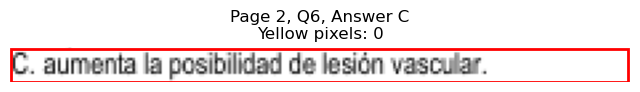

Page 2, Q6 - D: Detected box: x0=315.4, y0=379.7, x1=476.0, y1=392.4
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 750
Page 2, Q6, D: Yellow percentage: 0.0%


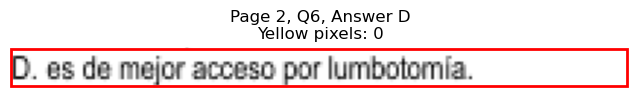


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)
Page 2, Q7 - A: Detected box: x0=56.6, y0=417.6, x1=187.5, y1=430.3
Page 2, Q7, A: Yellow pixels: 1713
Page 2, Q7, A: Total non-white pixels: 2548
Page 2, Q7, A: Yellow percentage: 67.2%


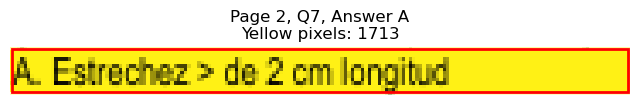

Page 2, Q7 - B: Detected box: x0=56.6, y0=430.2, x1=192.7, y1=442.9
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 806
Page 2, Q7, B: Yellow percentage: 0.0%


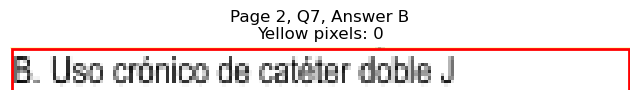

Page 2, Q7 - C: Detected box: x0=315.4, y0=417.6, x1=537.2, y1=430.3
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 1120
Page 2, Q7, C: Yellow percentage: 0.0%


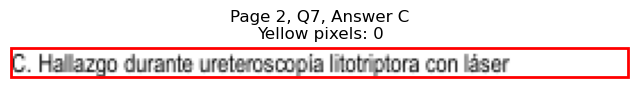

Page 2, Q7 - D: Detected box: x0=315.4, y0=430.2, x1=427.4, y1=442.9
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 572
Page 2, Q7, D: Yellow percentage: 0.0%


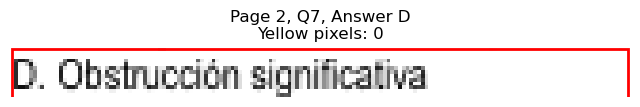


Page 2, Q7 - Selected Answer: A (based on yellow pixel count)
Page 2, Q8 - A: Detected box: x0=56.6, y0=468.1, x1=124.9, y1=480.7
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 331
Page 2, Q8, A: Yellow percentage: 0.0%


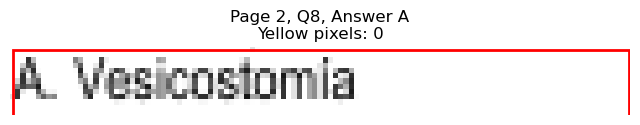

Page 2, Q8 - B: Detected box: x0=56.6, y0=480.8, x1=195.3, y1=493.4
Page 2, Q8, B: Yellow pixels: 1741
Page 2, Q8, B: Total non-white pixels: 2660
Page 2, Q8, B: Yellow percentage: 65.5%


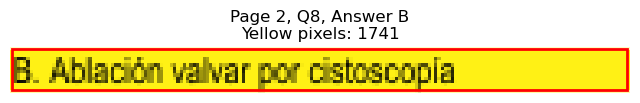

Page 2, Q8 - C: Detected box: x0=315.4, y0=468.1, x1=496.5, y1=480.7
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 891
Page 2, Q8, C: Yellow percentage: 0.0%


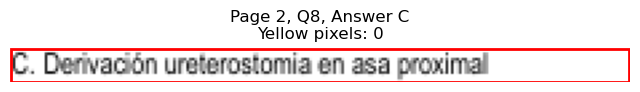

Page 2, Q8 - D: Detected box: x0=315.4, y0=480.8, x1=413.3, y1=493.4
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 481
Page 2, Q8, D: Yellow percentage: 0.0%


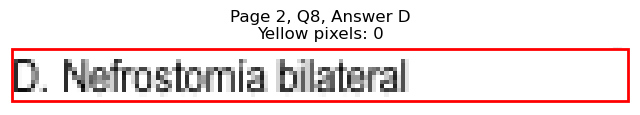


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)
Page 2, Q9 - A: Detected box: x0=56.6, y0=531.2, x1=124.5, y1=543.8
Page 2, Q9, A: Yellow pixels: 1308
Page 2, Q9, A: Total non-white pixels: 1547
Page 2, Q9, A: Yellow percentage: 84.6%


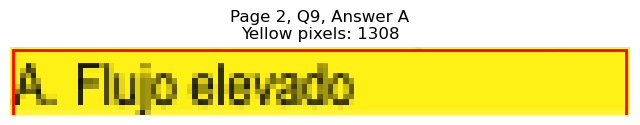

Page 2, Q9 - B: Detected box: x0=56.6, y0=543.8, x1=107.9, y1=556.4
Page 2, Q9, B: Yellow pixels: 99
Page 2, Q9, B: Total non-white pixels: 346
Page 2, Q9, B: Yellow percentage: 28.6%


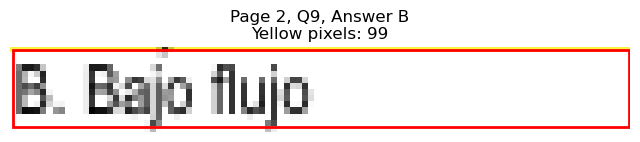

Page 2, Q9 - C: Detected box: x0=315.4, y0=531.2, x1=374.7, y1=543.8
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 270
Page 2, Q9, C: Yellow percentage: 0.0%


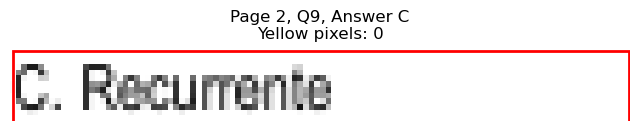

Page 2, Q9 - D: Detected box: x0=315.4, y0=543.8, x1=371.2, y1=556.4
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 261
Page 2, Q9, D: Yellow percentage: 0.0%


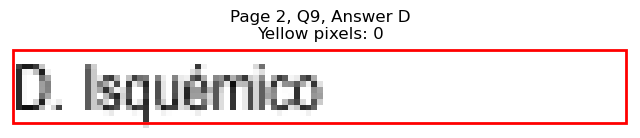


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)
Page 2, Q10 - A: Detected box: x0=56.6, y0=581.7, x1=232.2, y1=594.3
Page 2, Q10, A: Yellow pixels: 225
Page 2, Q10, A: Total non-white pixels: 1064
Page 2, Q10, A: Yellow percentage: 21.1%


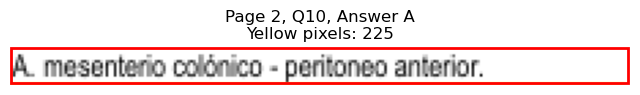

Page 2, Q10 - B: Detected box: x0=56.6, y0=594.3, x1=236.8, y1=606.9
Page 2, Q10, B: Yellow pixels: 2246
Page 2, Q10, B: Total non-white pixels: 2938
Page 2, Q10, B: Yellow percentage: 76.4%


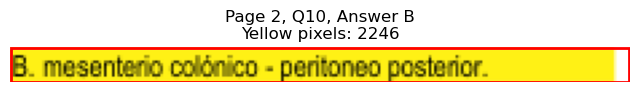

Page 2, Q10 - C: Detected box: x0=315.4, y0=581.7, x1=491.0, y1=594.3
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 859
Page 2, Q10, C: Yellow percentage: 0.0%


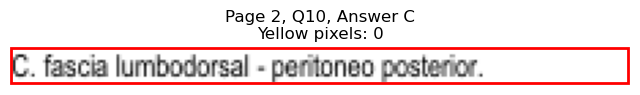

Page 2, Q10 - D: Detected box: x0=315.4, y0=594.3, x1=486.6, y1=606.9
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 823
Page 2, Q10, D: Yellow percentage: 0.0%


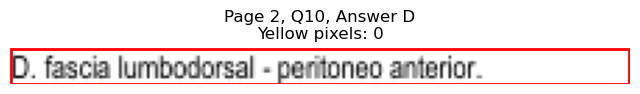


Page 2, Q10 - Selected Answer: B (based on yellow pixel count)
Page 2, Q11 - A: Detected box: x0=56.6, y0=644.8, x1=177.1, y1=657.5
Page 2, Q11, A: Yellow pixels: 0
Page 2, Q11, A: Total non-white pixels: 608
Page 2, Q11, A: Yellow percentage: 0.0%


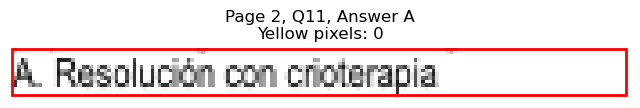

Page 2, Q11 - B: Detected box: x0=56.6, y0=657.4, x1=128.5, y1=670.1
Page 2, Q11, B: Yellow pixels: 0
Page 2, Q11, B: Total non-white pixels: 334
Page 2, Q11, B: Yellow percentage: 0.0%


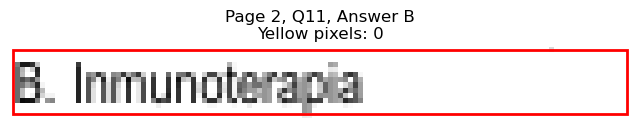

Page 2, Q11 - C: Detected box: x0=315.4, y0=644.8, x1=413.8, y1=657.5
Page 2, Q11, C: Yellow pixels: 149
Page 2, Q11, C: Total non-white pixels: 620
Page 2, Q11, C: Yellow percentage: 24.0%


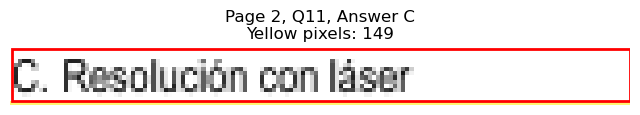

Page 2, Q11 - D: Detected box: x0=315.4, y0=657.4, x1=491.6, y1=670.1
Page 2, Q11, D: Yellow pixels: 2297
Page 2, Q11, D: Total non-white pixels: 3163
Page 2, Q11, D: Yellow percentage: 72.6%


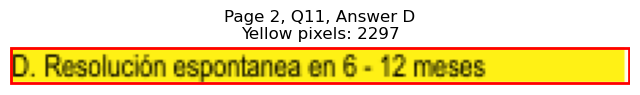


Page 2, Q11 - Selected Answer: D (based on yellow pixel count)
Page 2, Q12 - A: Detected box: x0=56.6, y0=695.4, x1=168.1, y1=708.0
Page 2, Q12, A: Yellow pixels: 0
Page 2, Q12, A: Total non-white pixels: 520
Page 2, Q12, A: Yellow percentage: 0.0%


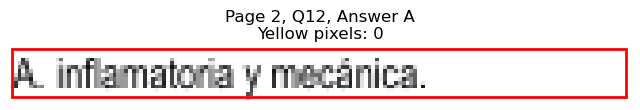

Page 2, Q12 - B: Detected box: x0=56.6, y0=708.0, x1=167.7, y1=720.6
Page 2, Q12, B: Yellow pixels: 0
Page 2, Q12, B: Total non-white pixels: 497
Page 2, Q12, B: Yellow percentage: 0.0%


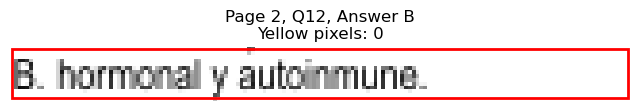

Page 2, Q12 - C: Detected box: x0=315.4, y0=695.4, x1=418.3, y1=708.0
Page 2, Q12, C: Yellow pixels: 1663
Page 2, Q12, C: Total non-white pixels: 2004
Page 2, Q12, C: Yellow percentage: 83.0%


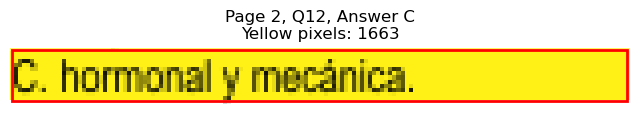

Page 2, Q12 - D: Detected box: x0=315.4, y0=708.0, x1=432.3, y1=720.6
Page 2, Q12, D: Yellow pixels: 166
Page 2, Q12, D: Total non-white pixels: 715
Page 2, Q12, D: Yellow percentage: 23.2%


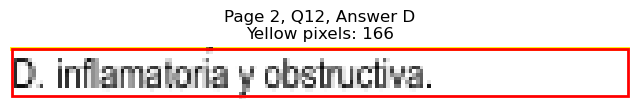


Page 2, Q12 - Selected Answer: C (based on yellow pixel count)

Page 3: Found 11 questions
Page 3, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=170.1, y1=127.3
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 565
Page 3, Q1, A: Yellow percentage: 0.0%


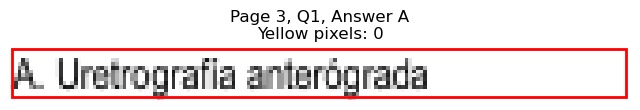

Page 3, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=144.0, y1=139.9
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 422
Page 3, Q1, B: Yellow percentage: 0.0%


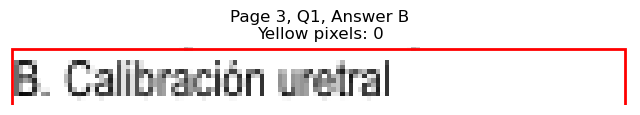

Page 3, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=471.0, y1=127.3
Page 3, Q1, C: Yellow pixels: 206
Page 3, Q1, C: Total non-white pixels: 916
Page 3, Q1, C: Yellow percentage: 22.5%


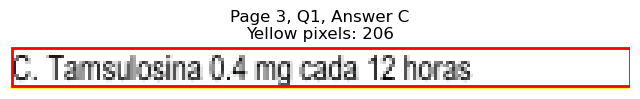

Page 3, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=377.2, y1=139.9
Page 3, Q1, D: Yellow pixels: 1245
Page 3, Q1, D: Total non-white pixels: 1469
Page 3, Q1, D: Yellow percentage: 84.8%


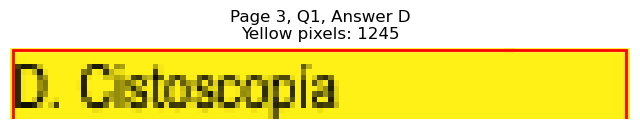


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)
Page 3, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=179.7, y1=177.8
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 571
Page 3, Q2, A: Yellow percentage: 0.0%


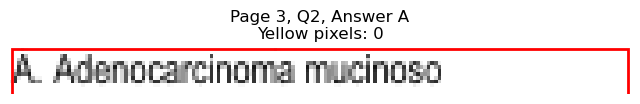

Page 3, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=146.7, y1=190.4
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 444
Page 3, Q2, B: Yellow percentage: 0.0%


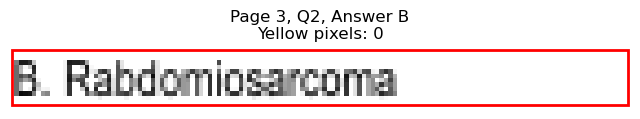

Page 3, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=458.9, y1=177.8
Page 3, Q2, C: Yellow pixels: 1977
Page 3, Q2, C: Total non-white pixels: 2522
Page 3, Q2, C: Yellow percentage: 78.4%


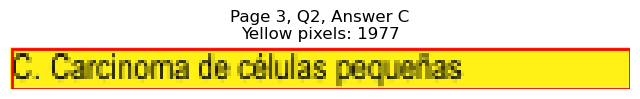

Page 3, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=366.2, y1=190.4
Page 3, Q2, D: Yellow pixels: 102
Page 3, Q2, D: Total non-white pixels: 330
Page 3, Q2, D: Yellow percentage: 30.9%


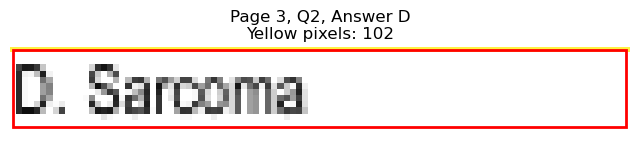


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)
Page 3, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=149.5, y1=228.3
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 437
Page 3, Q3, A: Yellow percentage: 0.0%


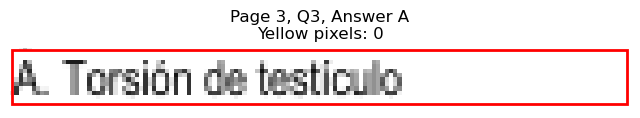

Page 3, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=116.4, y1=240.9
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 296
Page 3, Q3, B: Yellow percentage: 0.0%


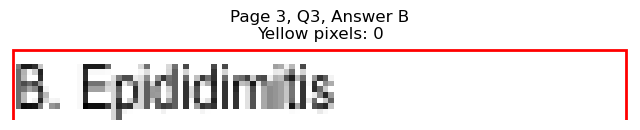

Page 3, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=368.2, y1=228.3
Page 3, Q3, C: Yellow pixels: 104
Page 3, Q3, C: Total non-white pixels: 363
Page 3, Q3, C: Yellow percentage: 28.7%


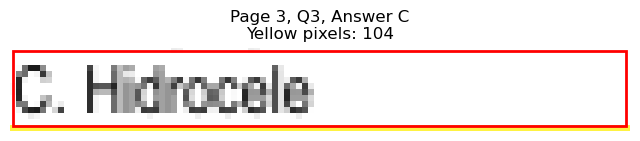

Page 3, Q3 - D: Detected box: x0=315.4, y0=228.2, x1=430.4, y1=240.9
Page 3, Q3, D: Yellow pixels: 1757
Page 3, Q3, D: Total non-white pixels: 2158
Page 3, Q3, D: Yellow percentage: 81.4%


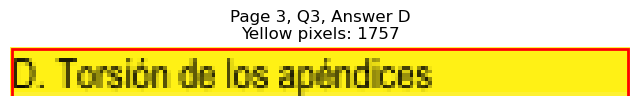


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)
Page 3, Q4 - A: Detected box: x0=56.6, y0=266.0, x1=88.8, y1=278.7
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 132
Page 3, Q4, A: Yellow percentage: 0.0%


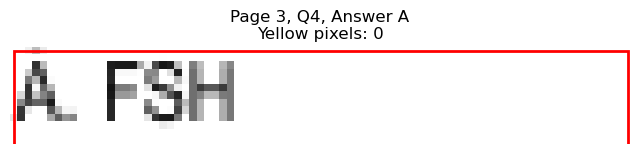

Page 3, Q4 - B: Detected box: x0=56.6, y0=278.8, x1=82.3, y1=291.4
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 99
Page 3, Q4, B: Yellow percentage: 0.0%


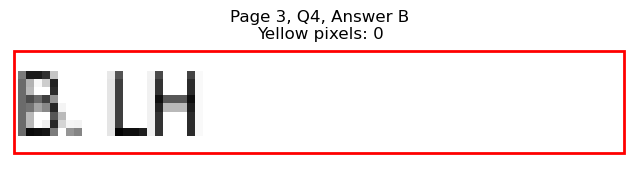

Page 3, Q4 - C: Detected box: x0=315.4, y0=266.0, x1=382.7, y1=278.7
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 322
Page 3, Q4, C: Yellow percentage: 0.0%


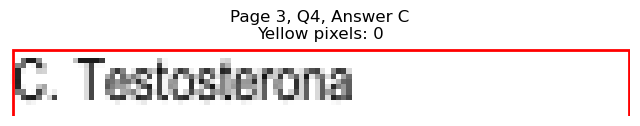

Page 3, Q4 - D: Detected box: x0=315.4, y0=278.8, x1=355.1, y1=291.4
Page 3, Q4, D: Yellow pixels: 1045
Page 3, Q4, D: Total non-white pixels: 1274
Page 3, Q4, D: Yellow percentage: 82.0%


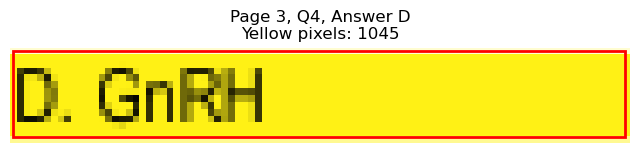


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)
Page 3, Q5 - A: Detected box: x0=56.6, y0=329.2, x1=185.7, y1=341.8
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 625
Page 3, Q5, A: Yellow percentage: 0.0%


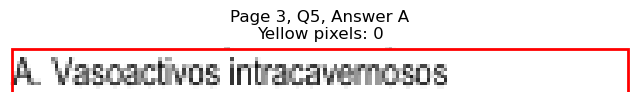

Page 3, Q5 - B: Detected box: x0=56.6, y0=341.9, x1=157.1, y1=354.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 470
Page 3, Q5, B: Yellow percentage: 0.0%


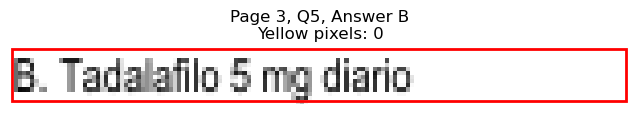

Page 3, Q5 - C: Detected box: x0=315.4, y0=329.2, x1=400.3, y1=341.8
Page 3, Q5, C: Yellow pixels: 1473
Page 3, Q5, C: Total non-white pixels: 1768
Page 3, Q5, C: Yellow percentage: 83.3%


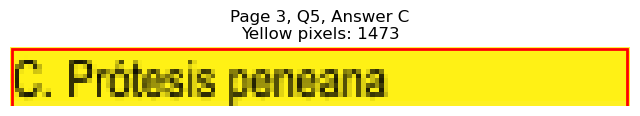

Page 3, Q5 - D: Detected box: x0=315.4, y0=341.9, x1=410.8, y1=354.6
Page 3, Q5, D: Yellow pixels: 145
Page 3, Q5, D: Total non-white pixels: 608
Page 3, Q5, D: Yellow percentage: 23.8%


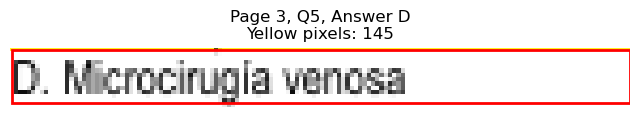


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)
Page 3, Q6 - A: Detected box: x0=56.6, y0=392.3, x1=214.8, y1=405.0
Page 3, Q6, A: Yellow pixels: 2096
Page 3, Q6, A: Total non-white pixels: 2717
Page 3, Q6, A: Yellow percentage: 77.1%


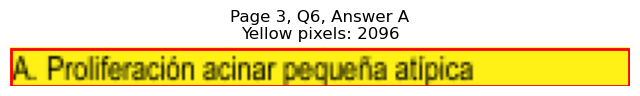

Page 3, Q6 - B: Detected box: x0=56.6, y0=404.9, x1=209.2, y1=417.6
Page 3, Q6, B: Yellow pixels: 199
Page 3, Q6, B: Total non-white pixels: 963
Page 3, Q6, B: Yellow percentage: 20.7%


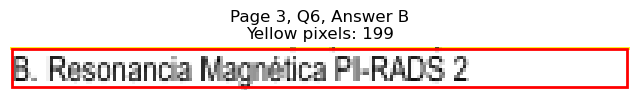

Page 3, Q6 - C: Detected box: x0=315.4, y0=392.3, x1=385.7, y1=405.0
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 335
Page 3, Q6, C: Yellow percentage: 0.0%


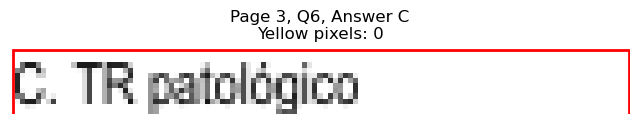

Page 3, Q6 - D: Detected box: x0=315.4, y0=404.9, x1=402.8, y1=417.6
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 428
Page 3, Q6, D: Yellow percentage: 0.0%


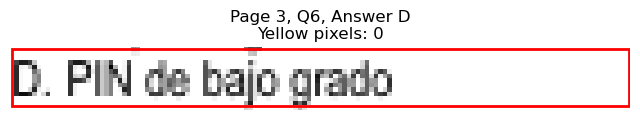


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)
Page 3, Q7 - A: Detected box: x0=56.6, y0=442.8, x1=190.1, y1=455.5
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 620
Page 3, Q7, A: Yellow percentage: 0.0%


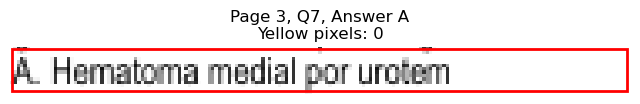

Page 3, Q7 - B: Detected box: x0=56.6, y0=455.5, x1=315.0, y1=468.1
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 1228
Page 3, Q7, B: Yellow percentage: 0.0%


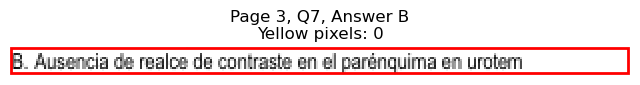

Page 3, Q7 - C: Detected box: x0=56.6, y0=468.1, x1=307.0, y1=480.7
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 1186
Page 3, Q7, C: Yellow percentage: 0.0%


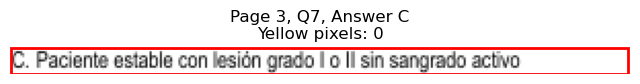

Page 3, Q7 - D: Detected box: x0=56.6, y0=480.8, x1=244.8, y1=493.4
Page 3, Q7, D: Yellow pixels: 2132
Page 3, Q7, D: Total non-white pixels: 3346
Page 3, Q7, D: Yellow percentage: 63.7%


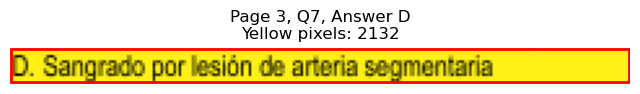


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)
Page 3, Q8 - A: Detected box: x0=56.6, y0=518.6, x1=121.5, y1=531.2
Page 3, Q8, A: Yellow pixels: 1261
Page 3, Q8, A: Total non-white pixels: 1624
Page 3, Q8, A: Yellow percentage: 77.6%


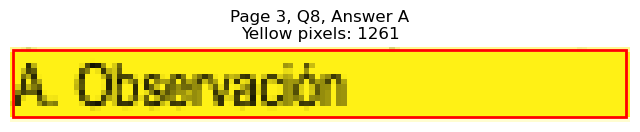

Page 3, Q8 - B: Detected box: x0=56.6, y0=531.2, x1=149.1, y1=543.8
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 577
Page 3, Q8, B: Yellow percentage: 0.0%


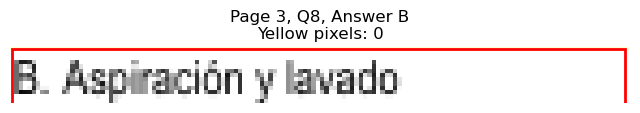

Page 3, Q8 - C: Detected box: x0=315.4, y0=518.6, x1=433.9, y1=531.2
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 581
Page 3, Q8, C: Yellow percentage: 0.0%


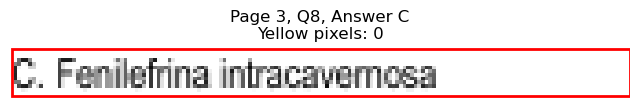

Page 3, Q8 - D: Detected box: x0=315.4, y0=531.2, x1=417.3, y1=543.8
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 498
Page 3, Q8, D: Yellow percentage: 0.0%


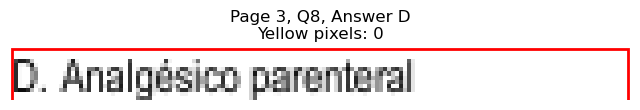


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)
Page 3, Q9 - A: Detected box: x0=56.6, y0=594.3, x1=75.9, y1=606.9
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 67
Page 3, Q9, A: Yellow percentage: 0.0%


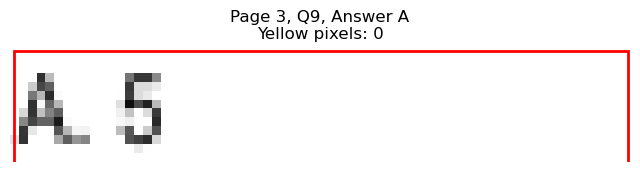

Page 3, Q9 - B: Detected box: x0=56.6, y0=606.9, x1=75.9, y1=619.5
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 73
Page 3, Q9, B: Yellow percentage: 0.0%


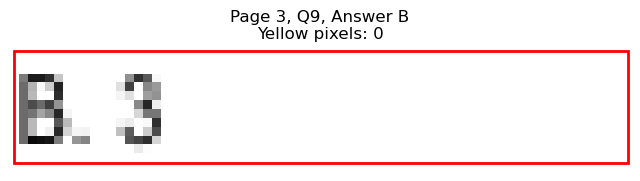

Page 3, Q9 - C: Detected box: x0=315.4, y0=594.3, x1=335.1, y1=606.9
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 133
Page 3, Q9, C: Yellow percentage: 0.0%


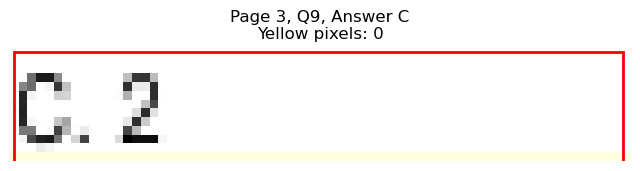

Page 3, Q9 - D: Detected box: x0=315.4, y0=606.9, x1=335.1, y1=619.5
Page 3, Q9, D: Yellow pixels: 869
Page 3, Q9, D: Total non-white pixels: 994
Page 3, Q9, D: Yellow percentage: 87.4%


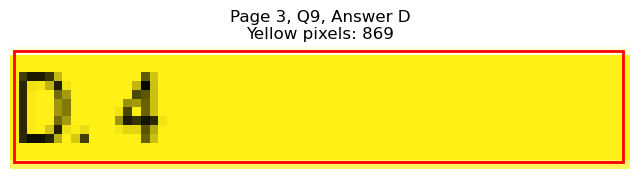


Page 3, Q9 - Selected Answer: D (based on yellow pixel count)
Page 3, Q10 - A: Detected box: x0=56.6, y0=644.8, x1=143.1, y1=657.5
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 441
Page 3, Q10, A: Yellow percentage: 0.0%


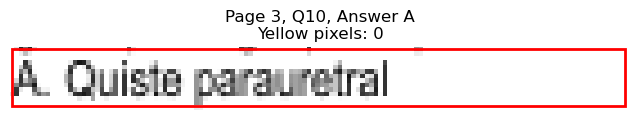

Page 3, Q10 - B: Detected box: x0=56.6, y0=657.4, x1=143.5, y1=670.1
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 432
Page 3, Q10, B: Yellow percentage: 0.0%


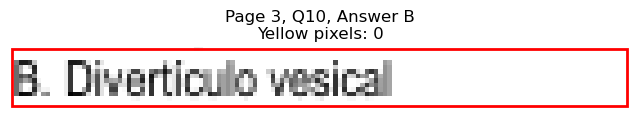

Page 3, Q10 - C: Detected box: x0=315.4, y0=644.8, x1=365.7, y1=657.5
Page 3, Q10, C: Yellow pixels: 1117
Page 3, Q10, C: Total non-white pixels: 1414
Page 3, Q10, C: Yellow percentage: 79.0%


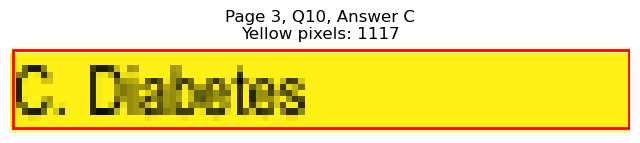

Page 3, Q10 - D: Detected box: x0=315.4, y0=657.4, x1=392.7, y1=670.1
Page 3, Q10, D: Yellow pixels: 128
Page 3, Q10, D: Total non-white pixels: 490
Page 3, Q10, D: Yellow percentage: 26.1%


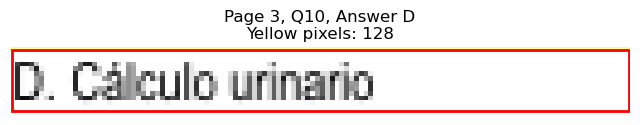


Page 3, Q10 - Selected Answer: C (based on yellow pixel count)
Page 3, Q11 - A: Detected box: x0=56.6, y0=695.4, x1=112.5, y1=708.0
Page 3, Q11, A: Yellow pixels: 107
Page 3, Q11, A: Total non-white pixels: 484
Page 3, Q11, A: Yellow percentage: 22.1%


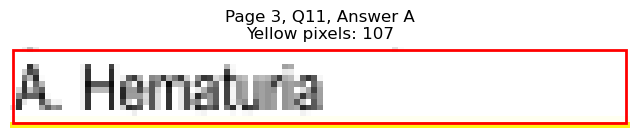

Page 3, Q11 - B: Detected box: x0=56.6, y0=708.0, x1=124.0, y1=720.6
Page 3, Q11, B: Yellow pixels: 1314
Page 3, Q11, B: Total non-white pixels: 1652
Page 3, Q11, B: Yellow percentage: 79.5%


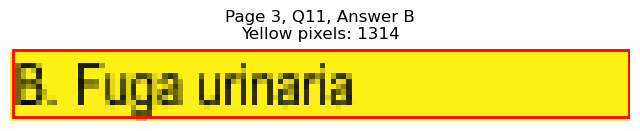

Page 3, Q11 - C: Detected box: x0=315.4, y0=695.4, x1=440.8, y1=708.0
Page 3, Q11, C: Yellow pixels: 0
Page 3, Q11, C: Total non-white pixels: 588
Page 3, Q11, C: Yellow percentage: 0.0%


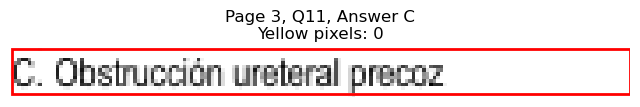

Page 3, Q11 - D: Detected box: x0=315.4, y0=708.0, x1=363.7, y1=720.6
Page 3, Q11, D: Yellow pixels: 0
Page 3, Q11, D: Total non-white pixels: 217
Page 3, Q11, D: Yellow percentage: 0.0%


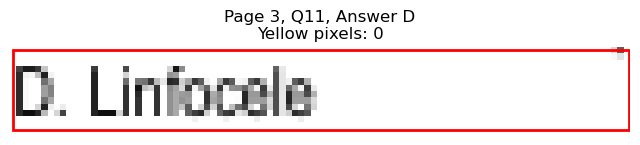


Page 3, Q11 - Selected Answer: B (based on yellow pixel count)

Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=244.4, y1=127.3
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 925
Page 4, Q1, A: Yellow percentage: 0.0%


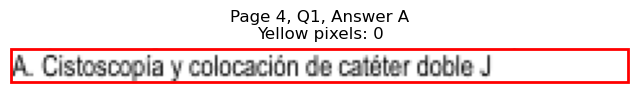

Page 4, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=158.1, y1=139.9
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 506
Page 4, Q1, B: Yellow percentage: 0.0%


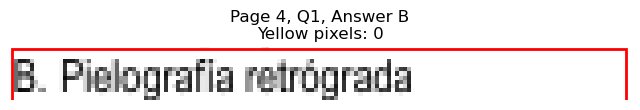

Page 4, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=485.7, y1=127.3
Page 4, Q1, C: Yellow pixels: 1989
Page 4, Q1, C: Total non-white pixels: 3094
Page 4, Q1, C: Yellow percentage: 64.3%


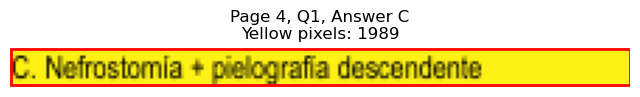

Page 4, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=416.3, y1=139.9
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 609
Page 4, Q1, D: Yellow percentage: 0.0%


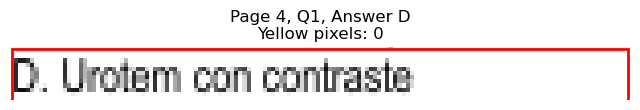


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)
Page 4, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=85.8, y1=190.4
Page 4, Q2, A: Yellow pixels: 80
Page 4, Q2, A: Total non-white pixels: 198
Page 4, Q2, A: Yellow percentage: 40.4%


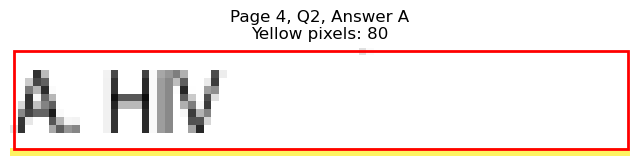

Page 4, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=106.5, y1=203.0
Page 4, Q2, B: Yellow pixels: 1125
Page 4, Q2, B: Total non-white pixels: 1313
Page 4, Q2, B: Yellow percentage: 85.7%


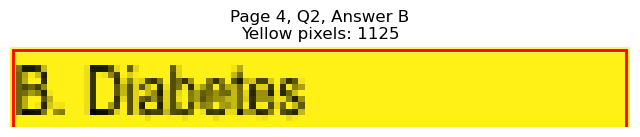

Page 4, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=404.8, y1=190.4
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 422
Page 4, Q2, C: Yellow percentage: 0.0%


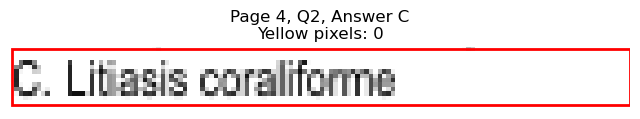

Page 4, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=381.7, y1=203.0
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 307
Page 4, Q2, D: Yellow percentage: 0.0%


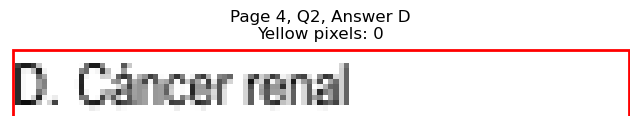


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)
Page 4, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=143.5, y1=266.1
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 447
Page 4, Q3, A: Yellow percentage: 0.0%


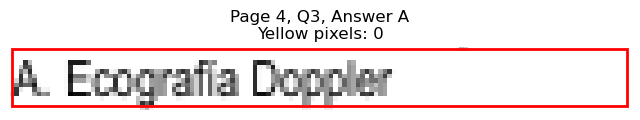

Page 4, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=118.0, y1=278.7
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 315
Page 4, Q3, B: Yellow percentage: 0.0%


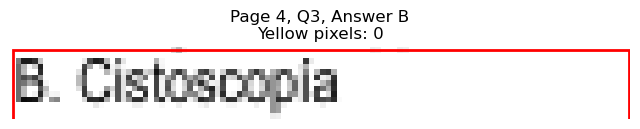

Page 4, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=473.5, y1=266.1
Page 4, Q3, C: Yellow pixels: 2073
Page 4, Q3, C: Total non-white pixels: 2926
Page 4, Q3, C: Yellow percentage: 70.8%


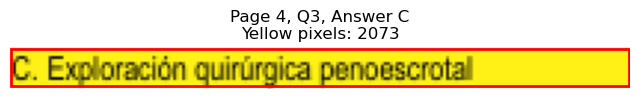

Page 4, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=523.2, y1=278.7
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 1272
Page 4, Q3, D: Yellow percentage: 0.0%


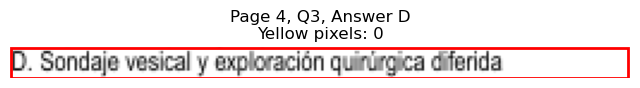


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)
Page 4, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=109.9, y1=329.2
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 247
Page 4, Q4, A: Yellow percentage: 0.0%


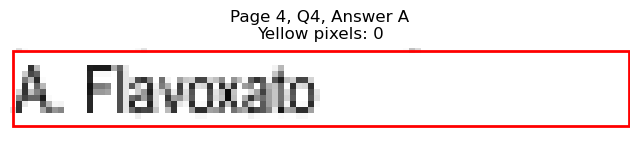

Page 4, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=125.4, y1=341.8
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 324
Page 4, Q4, B: Yellow percentage: 0.0%


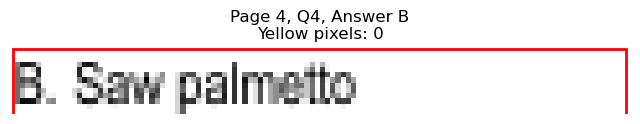

Page 4, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=381.2, y1=329.2
Page 4, Q4, C: Yellow pixels: 1173
Page 4, Q4, C: Total non-white pixels: 1638
Page 4, Q4, C: Yellow percentage: 71.6%


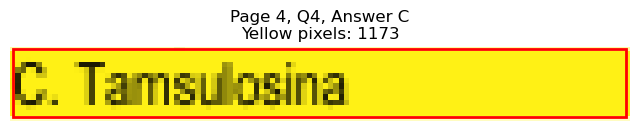

Page 4, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=375.2, y1=341.8
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 402
Page 4, Q4, D: Yellow percentage: 0.0%


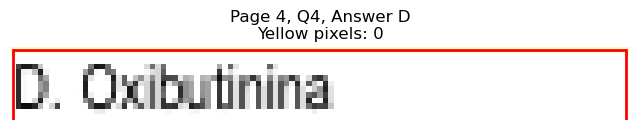


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)
Page 4, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=166.6, y1=379.8
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 521
Page 4, Q5, A: Yellow percentage: 0.0%


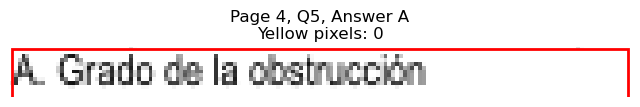

Page 4, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=143.1, y1=392.4
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 432
Page 4, Q5, B: Yellow percentage: 0.0%


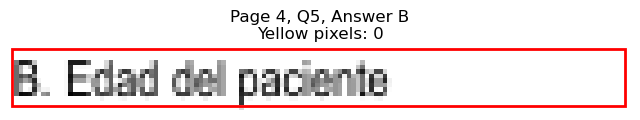

Page 4, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=408.8, y1=379.8
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 593
Page 4, Q5, C: Yellow percentage: 0.0%


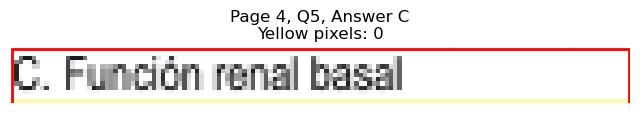

Page 4, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=436.9, y1=392.4
Page 4, Q5, D: Yellow pixels: 1618
Page 4, Q5, D: Total non-white pixels: 2408
Page 4, Q5, D: Yellow percentage: 67.2%


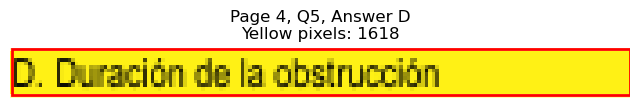


Page 4, Q5 - Selected Answer: D (based on yellow pixel count)
Page 4, Q6 - A: Detected box: x0=56.6, y0=430.2, x1=112.5, y1=442.9
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 357
Page 4, Q6, A: Yellow percentage: 0.0%


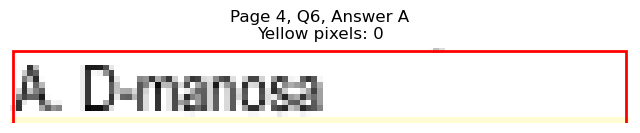

Page 4, Q6 - B: Detected box: x0=56.6, y0=442.8, x1=97.3, y1=455.5
Page 4, Q6, B: Yellow pixels: 1047
Page 4, Q6, B: Total non-white pixels: 1288
Page 4, Q6, B: Yellow percentage: 81.3%


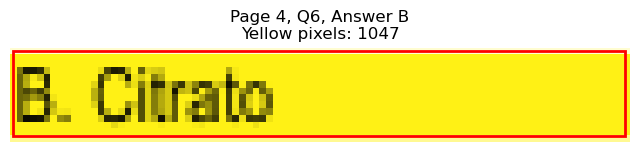

Page 4, Q6 - C: Detected box: x0=315.4, y0=430.2, x1=374.2, y1=442.9
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 255
Page 4, Q6, C: Yellow percentage: 0.0%


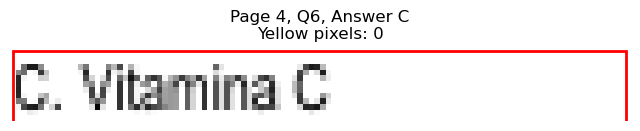

Page 4, Q6 - D: Detected box: x0=315.4, y0=442.8, x1=386.7, y1=455.5
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 315
Page 4, Q6, D: Yellow percentage: 0.0%


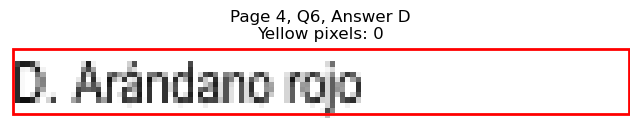


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)
Page 4, Q7 - A: Detected box: x0=56.6, y0=480.8, x1=211.7, y1=493.4
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 669
Page 4, Q7, A: Yellow percentage: 0.0%


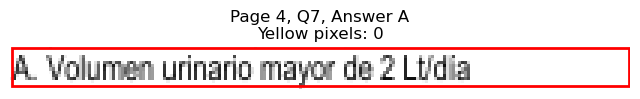

Page 4, Q7 - B: Detected box: x0=56.6, y0=493.4, x1=180.7, y1=506.0
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 583
Page 4, Q7, B: Yellow percentage: 0.0%


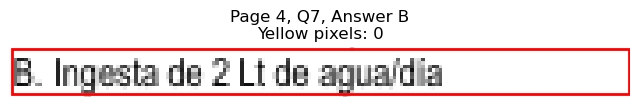

Page 4, Q7 - C: Detected box: x0=315.4, y0=480.8, x1=390.2, y1=493.4
Page 4, Q7, C: Yellow pixels: 126
Page 4, Q7, C: Total non-white pixels: 490
Page 4, Q7, C: Yellow percentage: 25.7%


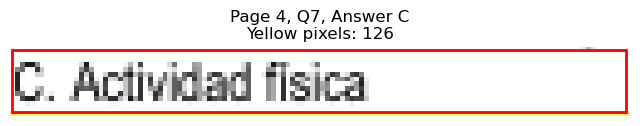

Page 4, Q7 - D: Detected box: x0=315.4, y0=493.4, x1=445.4, y1=506.0
Page 4, Q7, D: Yellow pixels: 1849
Page 4, Q7, D: Total non-white pixels: 2355
Page 4, Q7, D: Yellow percentage: 78.5%


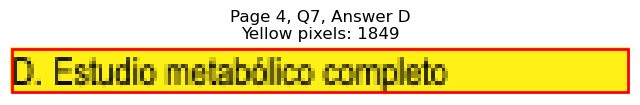


Page 4, Q7 - Selected Answer: D (based on yellow pixel count)
Page 4, Q8 - A: Detected box: x0=56.6, y0=531.2, x1=179.2, y1=543.8
Page 4, Q8, A: Yellow pixels: 1810
Page 4, Q8, A: Total non-white pixels: 2262
Page 4, Q8, A: Yellow percentage: 80.0%


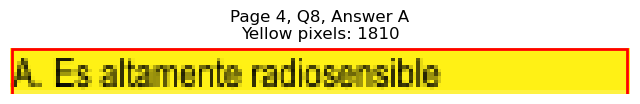

Page 4, Q8 - B: Detected box: x0=56.6, y0=543.8, x1=296.1, y1=556.4
Page 4, Q8, B: Yellow pixels: 291
Page 4, Q8, B: Total non-white pixels: 1437
Page 4, Q8, B: Yellow percentage: 20.3%


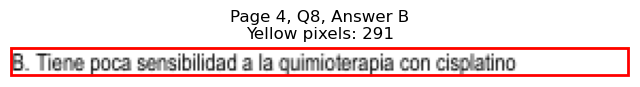

Page 4, Q8 - C: Detected box: x0=56.6, y0=556.5, x1=384.2, y1=569.1
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 1540
Page 4, Q8, C: Yellow percentage: 0.0%


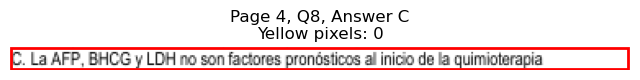

Page 4, Q8 - D: Detected box: x0=56.6, y0=569.1, x1=200.2, y1=581.7
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 693
Page 4, Q8, D: Yellow percentage: 0.0%


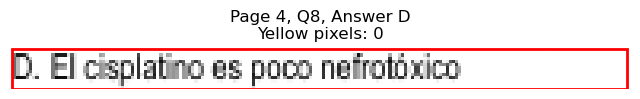


Page 4, Q8 - Selected Answer: A (based on yellow pixel count)
Page 4, Q9 - A: Detected box: x0=56.6, y0=619.6, x1=80.9, y1=632.3
Page 4, Q9, A: Yellow pixels: 831
Page 4, Q9, A: Total non-white pixels: 1050
Page 4, Q9, A: Yellow percentage: 79.1%


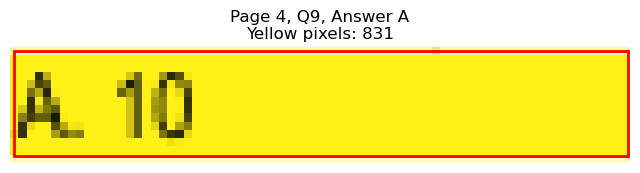

Page 4, Q9 - B: Detected box: x0=56.6, y0=632.2, x1=75.9, y1=644.9
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 143
Page 4, Q9, B: Yellow percentage: 0.0%


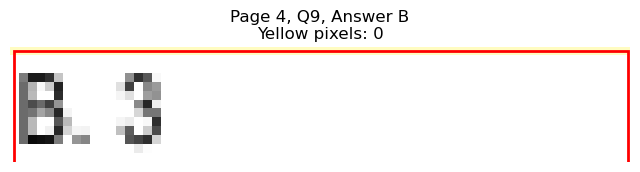

Page 4, Q9 - C: Detected box: x0=315.4, y0=619.6, x1=335.1, y1=632.3
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 69
Page 4, Q9, C: Yellow percentage: 0.0%


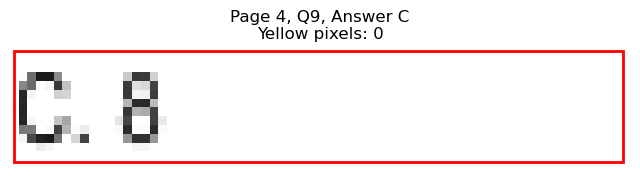

Page 4, Q9 - D: Detected box: x0=315.4, y0=632.2, x1=335.1, y1=644.9
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 71
Page 4, Q9, D: Yellow percentage: 0.0%


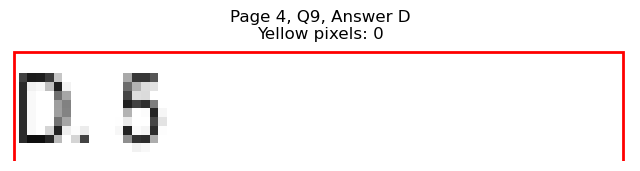


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)
Page 4, Q10 - A: Detected box: x0=56.6, y0=695.4, x1=171.1, y1=708.0
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 576
Page 4, Q10, A: Yellow percentage: 0.0%


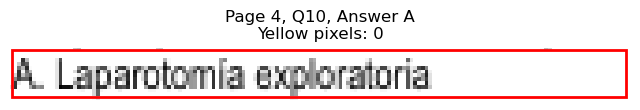

Page 4, Q10 - B: Detected box: x0=56.6, y0=708.0, x1=302.8, y1=720.6
Page 4, Q10, B: Yellow pixels: 297
Page 4, Q10, B: Total non-white pixels: 1495
Page 4, Q10, B: Yellow percentage: 19.9%


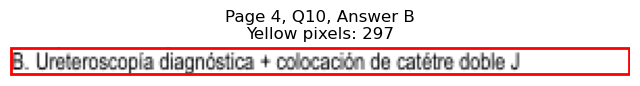

Page 4, Q10 - C: Detected box: x0=56.6, y0=720.6, x1=212.7, y1=733.2
Page 4, Q10, C: Yellow pixels: 2100
Page 4, Q10, C: Total non-white pixels: 2898
Page 4, Q10, C: Yellow percentage: 72.5%


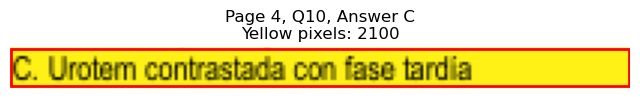

Page 4, Q10 - D: Detected box: x0=56.6, y0=733.2, x1=168.1, y1=745.8
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 704
Page 4, Q10, D: Yellow percentage: 0.0%


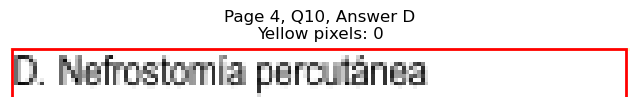


Page 4, Q10 - Selected Answer: C (based on yellow pixel count)

Page 5: Found 11 questions
Page 5, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=118.9, y1=102.1
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 279
Page 5, Q1, A: Yellow percentage: 0.0%


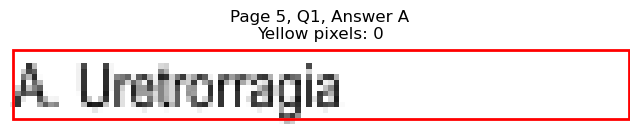

Page 5, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=153.6, y1=114.7
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 490
Page 5, Q1, B: Yellow percentage: 0.0%


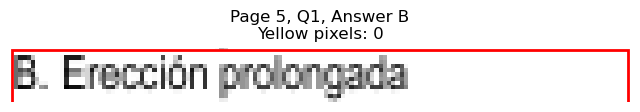

Page 5, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=480.0, y1=102.1
Page 5, Q1, C: Yellow pixels: 215
Page 5, Q1, C: Total non-white pixels: 1016
Page 5, Q1, C: Yellow percentage: 21.2%


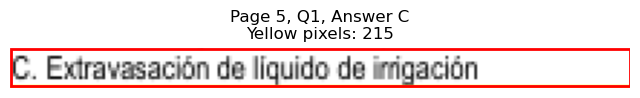

Page 5, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=441.4, y1=114.7
Page 5, Q1, D: Yellow pixels: 1844
Page 5, Q1, D: Total non-white pixels: 2301
Page 5, Q1, D: Yellow percentage: 80.1%


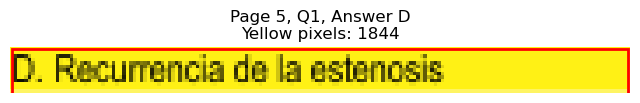


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)
Page 5, Q2 - A: Detected box: x0=56.6, y0=139.9, x1=190.1, y1=152.6
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 653
Page 5, Q2, A: Yellow percentage: 0.0%


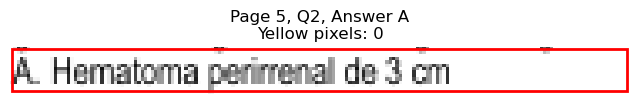

Page 5, Q2 - B: Detected box: x0=56.6, y0=152.5, x1=220.8, y1=165.2
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 795
Page 5, Q2, B: Yellow percentage: 0.0%


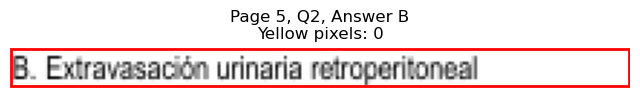

Page 5, Q2 - C: Detected box: x0=315.4, y0=139.9, x1=515.1, y1=152.6
Page 5, Q2, C: Yellow pixels: 225
Page 5, Q2, C: Total non-white pixels: 1225
Page 5, Q2, C: Yellow percentage: 18.4%


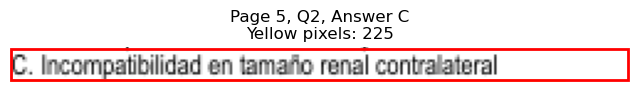

Page 5, Q2 - D: Detected box: x0=315.4, y0=152.5, x1=485.5, y1=165.2
Page 5, Q2, D: Yellow pixels: 2226
Page 5, Q2, D: Total non-white pixels: 3094
Page 5, Q2, D: Yellow percentage: 71.9%


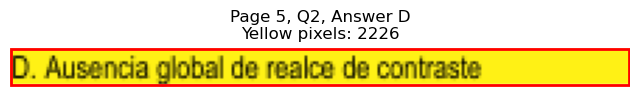


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)
Page 5, Q3 - A: Detected box: x0=56.6, y0=190.3, x1=115.5, y1=203.0
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 261
Page 5, Q3, A: Yellow percentage: 0.0%


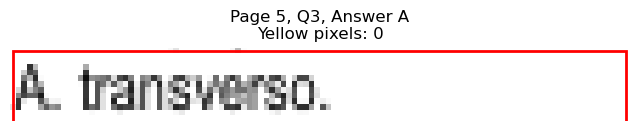

Page 5, Q3 - B: Detected box: x0=56.6, y0=202.9, x1=138.5, y1=215.6
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 402
Page 5, Q3, B: Yellow percentage: 0.0%


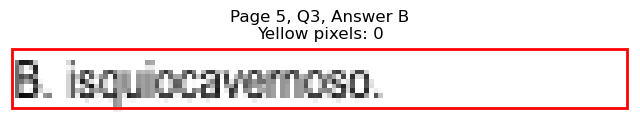

Page 5, Q3 - C: Detected box: x0=315.4, y0=190.3, x1=374.7, y1=203.0
Page 5, Q3, C: Yellow pixels: 1243
Page 5, Q3, C: Total non-white pixels: 1430
Page 5, Q3, C: Yellow percentage: 86.9%


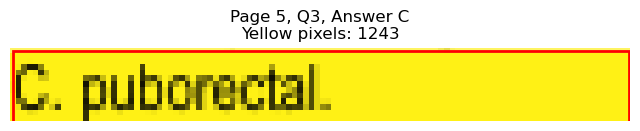

Page 5, Q3 - D: Detected box: x0=315.4, y0=202.9, x1=395.8, y1=215.6
Page 5, Q3, D: Yellow pixels: 130
Page 5, Q3, D: Total non-white pixels: 511
Page 5, Q3, D: Yellow percentage: 25.4%


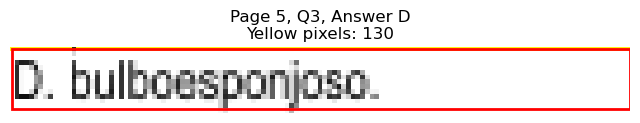


Page 5, Q3 - Selected Answer: C (based on yellow pixel count)
Page 5, Q4 - A: Detected box: x0=56.6, y0=253.4, x1=259.8, y1=266.1
Page 5, Q4, A: Yellow pixels: 2183
Page 5, Q4, A: Total non-white pixels: 3164
Page 5, Q4, A: Yellow percentage: 69.0%


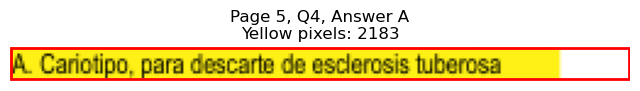

Page 5, Q4 - B: Detected box: x0=56.6, y0=266.0, x1=193.2, y1=278.7
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 869
Page 5, Q4, B: Yellow percentage: 0.0%


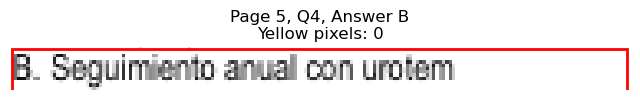

Page 5, Q4 - C: Detected box: x0=315.4, y0=253.4, x1=438.9, y1=266.1
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 629
Page 5, Q4, C: Yellow percentage: 0.0%


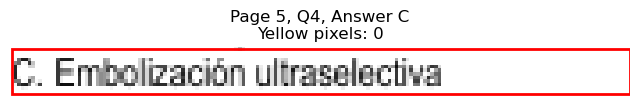

Page 5, Q4 - D: Detected box: x0=315.4, y0=266.0, x1=394.7, y1=278.7
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 370
Page 5, Q4, D: Yellow percentage: 0.0%


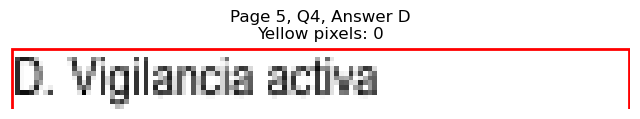


Page 5, Q4 - Selected Answer: A (based on yellow pixel count)
Page 5, Q5 - A: Detected box: x0=56.6, y0=316.6, x1=171.6, y1=329.2
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 560
Page 5, Q5, A: Yellow percentage: 0.0%


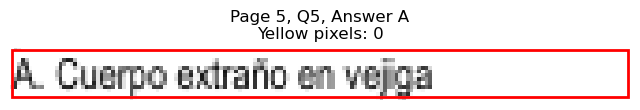

Page 5, Q5 - B: Detected box: x0=56.6, y0=329.2, x1=157.1, y1=341.8
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 459
Page 5, Q5, B: Yellow percentage: 0.0%


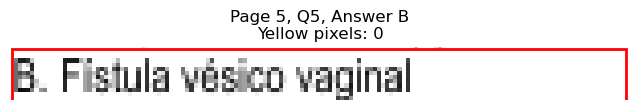

Page 5, Q5 - C: Detected box: x0=315.4, y0=316.6, x1=414.3, y1=329.2
Page 5, Q5, C: Yellow pixels: 150
Page 5, Q5, C: Total non-white pixels: 621
Page 5, Q5, C: Yellow percentage: 24.2%


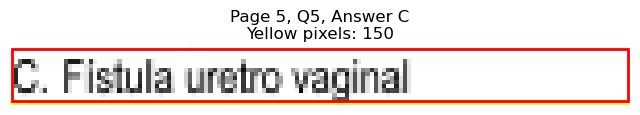

Page 5, Q5 - D: Detected box: x0=315.4, y0=329.2, x1=415.3, y1=341.8
Page 5, Q5, D: Yellow pixels: 1614
Page 5, Q5, D: Total non-white pixels: 1963
Page 5, Q5, D: Yellow percentage: 82.2%


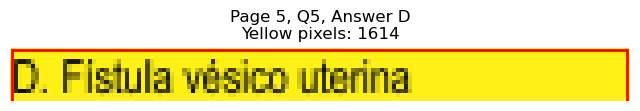


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)
Page 5, Q6 - A: Detected box: x0=56.6, y0=392.3, x1=135.5, y1=405.0
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 378
Page 5, Q6, A: Yellow percentage: 0.0%


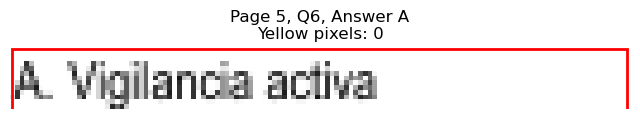

Page 5, Q6 - B: Detected box: x0=56.6, y0=404.9, x1=159.1, y1=417.6
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 491
Page 5, Q6, B: Yellow percentage: 0.0%


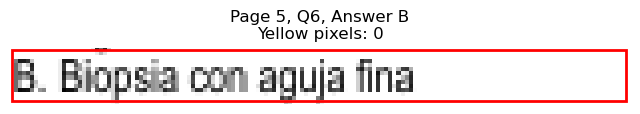

Page 5, Q6 - C: Detected box: x0=315.4, y0=392.3, x1=396.8, y1=405.0
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 520
Page 5, Q6, C: Yellow percentage: 0.0%


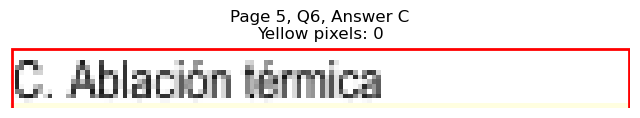

Page 5, Q6 - D: Detected box: x0=315.4, y0=404.9, x1=408.3, y1=417.6
Page 5, Q6, D: Yellow pixels: 1529
Page 5, Q6, D: Total non-white pixels: 2016
Page 5, Q6, D: Yellow percentage: 75.8%


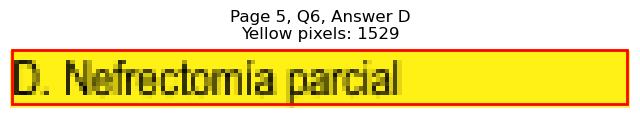


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)
Page 5, Q7 - A: Detected box: x0=56.6, y0=468.1, x1=176.2, y1=480.7
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 587
Page 5, Q7, A: Yellow percentage: 0.0%


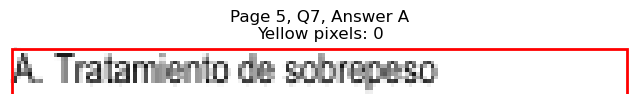

Page 5, Q7 - B: Detected box: x0=56.6, y0=480.8, x1=169.1, y1=493.4
Page 5, Q7, B: Yellow pixels: 1526
Page 5, Q7, B: Total non-white pixels: 2296
Page 5, Q7, B: Yellow percentage: 66.5%


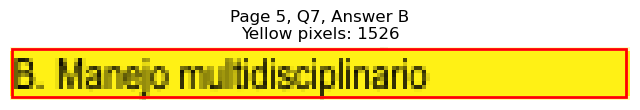

Page 5, Q7 - C: Detected box: x0=315.4, y0=468.1, x1=439.4, y1=480.7
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 605
Page 5, Q7, C: Yellow percentage: 0.0%


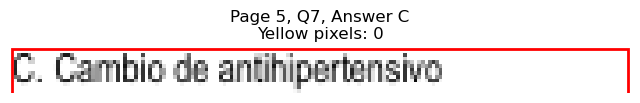

Page 5, Q7 - D: Detected box: x0=315.4, y0=480.8, x1=379.7, y1=493.4
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 329
Page 5, Q7, D: Yellow percentage: 0.0%


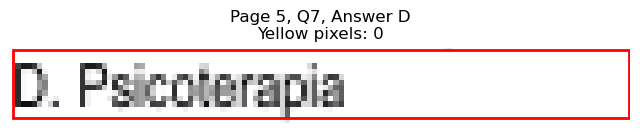


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)
Page 5, Q8 - A: Detected box: x0=56.6, y0=531.2, x1=310.5, y1=543.8
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 1186
Page 5, Q8, A: Yellow percentage: 0.0%


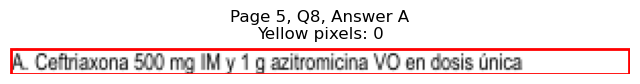

Page 5, Q8 - B: Detected box: x0=56.6, y0=543.8, x1=186.1, y1=556.4
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 618
Page 5, Q8, B: Yellow percentage: 0.0%


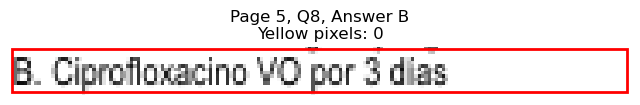

Page 5, Q8 - C: Detected box: x0=56.6, y0=556.5, x1=311.0, y1=569.1
Page 5, Q8, C: Yellow pixels: 3042
Page 5, Q8, C: Total non-white pixels: 4270
Page 5, Q8, C: Yellow percentage: 71.2%


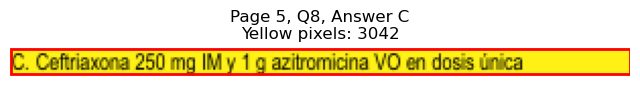

Page 5, Q8 - D: Detected box: x0=56.6, y0=569.1, x1=293.4, y1=581.7
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 1418
Page 5, Q8, D: Yellow percentage: 0.0%


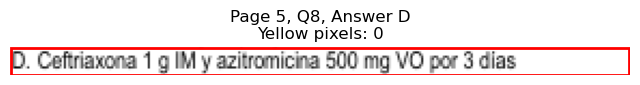


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)
Page 5, Q9 - A: Detected box: x0=56.6, y0=606.9, x1=112.5, y1=619.5
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 269
Page 5, Q9, A: Yellow percentage: 0.0%


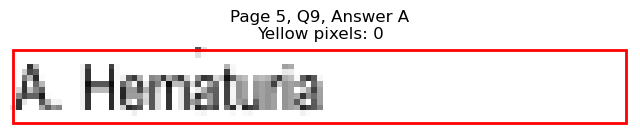

Page 5, Q9 - B: Detected box: x0=56.6, y0=619.6, x1=106.9, y1=632.3
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 225
Page 5, Q9, B: Yellow percentage: 0.0%


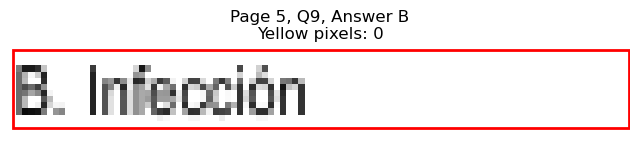

Page 5, Q9 - C: Detected box: x0=315.4, y0=606.9, x1=364.1, y1=619.5
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 218
Page 5, Q9, C: Yellow percentage: 0.0%


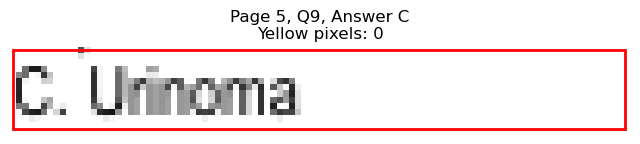

Page 5, Q9 - D: Detected box: x0=315.4, y0=102.0, x1=378.7, y1=114.7
Page 5, Q9, D: Yellow pixels: 1069
Page 5, Q9, D: Total non-white pixels: 1482
Page 5, Q9, D: Yellow percentage: 72.1%


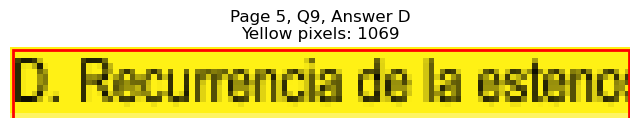


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)
Page 5, Q10 - A: Detected box: x0=56.6, y0=682.6, x1=121.9, y1=695.3
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 290
Page 5, Q10, A: Yellow percentage: 0.0%


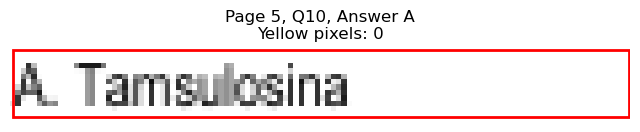

Page 5, Q10 - B: Detected box: x0=56.6, y0=695.4, x1=115.5, y1=708.0
Page 5, Q10, B: Yellow pixels: 1196
Page 5, Q10, B: Total non-white pixels: 1430
Page 5, Q10, B: Yellow percentage: 83.6%


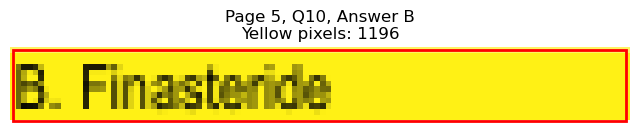

Page 5, Q10 - C: Detected box: x0=315.4, y0=682.6, x1=377.2, y1=695.3
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 286
Page 5, Q10, C: Yellow percentage: 0.0%


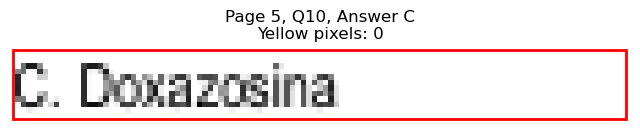

Page 5, Q10 - D: Detected box: x0=315.4, y0=695.4, x1=375.2, y1=708.0
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 291
Page 5, Q10, D: Yellow percentage: 0.0%


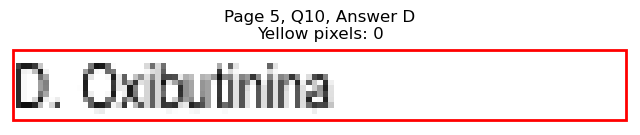


Page 5, Q10 - Selected Answer: B (based on yellow pixel count)
Page 5, Q11 - A: Detected box: x0=56.6, y0=733.2, x1=101.9, y1=745.8
Page 5, Q11, A: Yellow pixels: 1095
Page 5, Q11, A: Total non-white pixels: 1248
Page 5, Q11, A: Yellow percentage: 87.7%


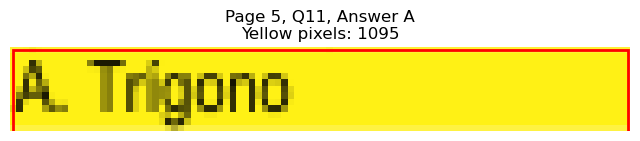

Page 5, Q11 - B: Detected box: x0=56.6, y0=745.8, x1=126.5, y1=758.4
Page 5, Q11, B: Yellow pixels: 120
Page 5, Q11, B: Total non-white pixels: 457
Page 5, Q11, B: Yellow percentage: 26.3%


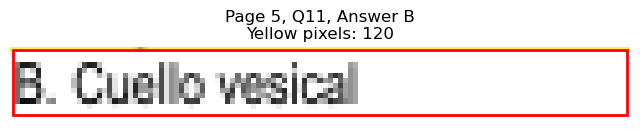

Page 5, Q11 - C: Detected box: x0=315.4, y0=733.2, x1=387.2, y1=745.8
Page 5, Q11, C: Yellow pixels: 0
Page 5, Q11, C: Total non-white pixels: 318
Page 5, Q11, C: Yellow percentage: 0.0%


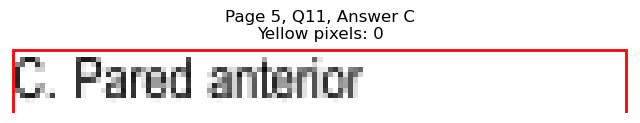

Page 5, Q11 - D: Detected box: x0=315.4, y0=745.8, x1=391.8, y1=758.4
Page 5, Q11, D: Yellow pixels: 0
Page 5, Q11, D: Total non-white pixels: 379
Page 5, Q11, D: Yellow percentage: 0.0%


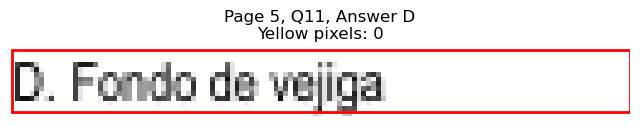


Page 5, Q11 - Selected Answer: A (based on yellow pixel count)

Page 6: Found 12 questions
Page 6, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=143.5, y1=114.7
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 408
Page 6, Q1, A: Yellow percentage: 0.0%


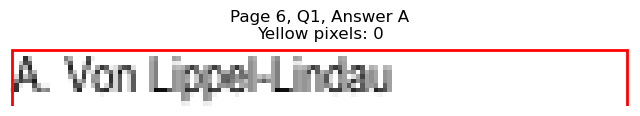

Page 6, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=121.0, y1=127.3
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 282
Page 6, Q1, B: Yellow percentage: 0.0%


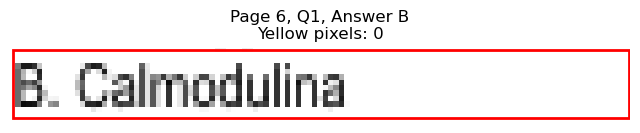

Page 6, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=370.6, y1=114.7
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 369
Page 6, Q1, C: Yellow percentage: 0.0%


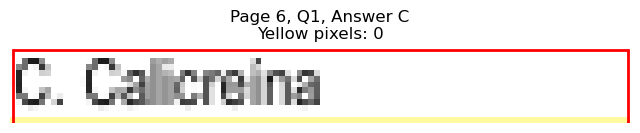

Page 6, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=389.2, y1=127.3
Page 6, Q1, D: Yellow pixels: 1253
Page 6, Q1, D: Total non-white pixels: 1750
Page 6, Q1, D: Yellow percentage: 71.6%


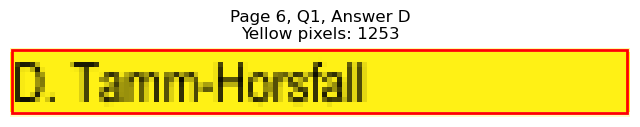


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)
Page 6, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=136.0, y1=165.2
Page 6, Q2, A: Yellow pixels: 1415
Page 6, Q2, A: Total non-white pixels: 1820
Page 6, Q2, A: Yellow percentage: 77.7%


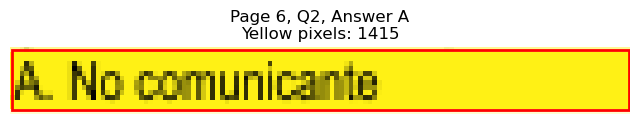

Page 6, Q2 - B: Detected box: x0=56.6, y0=165.1, x1=124.0, y1=177.8
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 425
Page 6, Q2, B: Yellow percentage: 0.0%


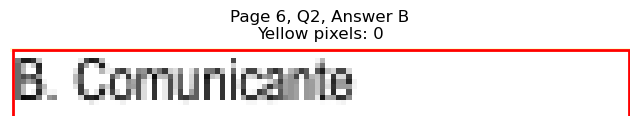

Page 6, Q2 - C: Detected box: x0=315.4, y0=152.5, x1=425.3, y1=165.2
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 545
Page 6, Q2, C: Yellow percentage: 0.0%


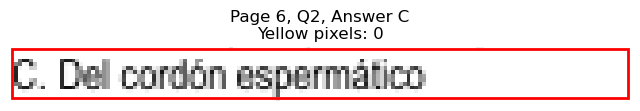

Page 6, Q2 - D: Detected box: x0=315.4, y0=165.1, x1=404.8, y1=177.8
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 428
Page 6, Q2, D: Yellow percentage: 0.0%


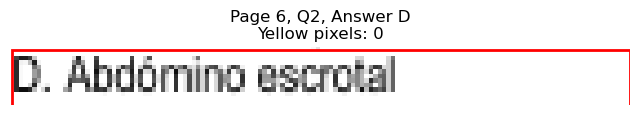


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)
Page 6, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=255.6, y1=240.9
Page 6, Q3, A: Yellow pixels: 2158
Page 6, Q3, A: Total non-white pixels: 2940
Page 6, Q3, A: Yellow percentage: 73.4%


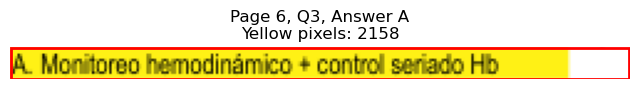

Page 6, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=150.5, y1=253.5
Page 6, Q3, B: Yellow pixels: 145
Page 6, Q3, B: Total non-white pixels: 612
Page 6, Q3, B: Yellow percentage: 23.7%


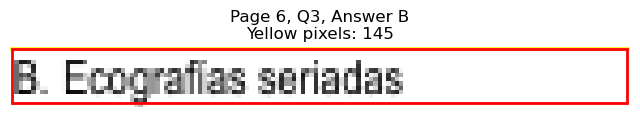

Page 6, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=419.3, y1=240.9
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 524
Page 6, Q3, C: Yellow percentage: 0.0%


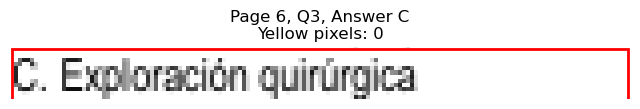

Page 6, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=396.2, y1=253.5
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 388
Page 6, Q3, D: Yellow percentage: 0.0%


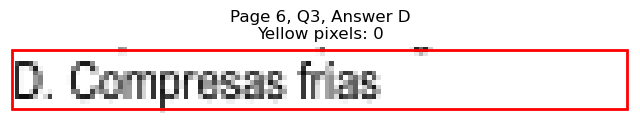


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)
Page 6, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=172.1, y1=304.0
Page 6, Q4, A: Yellow pixels: 1717
Page 6, Q4, A: Total non-white pixels: 2338
Page 6, Q4, A: Yellow percentage: 73.4%


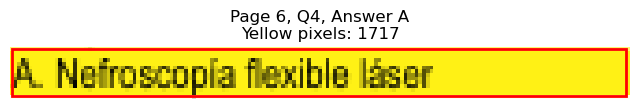

Page 6, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=101.9, y1=316.6
Page 6, Q4, B: Yellow pixels: 95
Page 6, Q4, B: Total non-white pixels: 395
Page 6, Q4, B: Yellow percentage: 24.1%


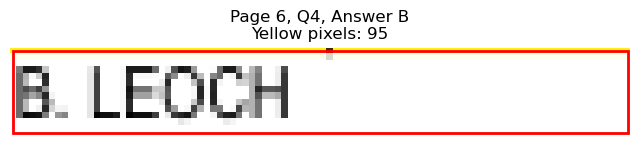

Page 6, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=433.9, y1=304.0
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 575
Page 6, Q4, C: Yellow percentage: 0.0%


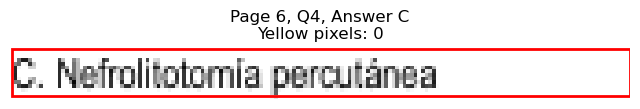

Page 6, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=459.4, y1=316.6
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 734
Page 6, Q4, D: Yellow percentage: 0.0%


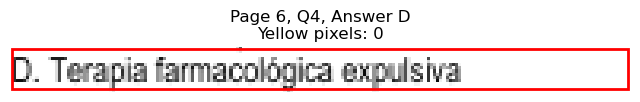


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)
Page 6, Q5 - A: Detected box: x0=56.6, y0=341.9, x1=132.5, y1=354.6
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 383
Page 6, Q5, A: Yellow percentage: 0.0%


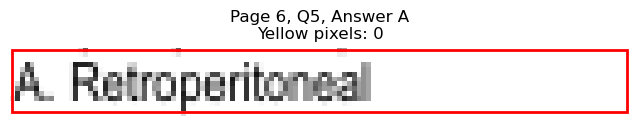

Page 6, Q5 - B: Detected box: x0=56.6, y0=354.5, x1=164.5, y1=367.2
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 527
Page 6, Q5, B: Yellow percentage: 0.0%


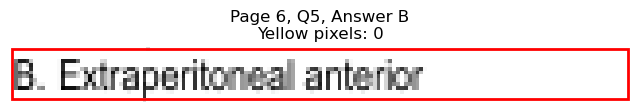

Page 6, Q5 - C: Detected box: x0=315.4, y0=341.9, x1=387.8, y1=354.6
Page 6, Q5, C: Yellow pixels: 1326
Page 6, Q5, C: Total non-white pixels: 1722
Page 6, Q5, C: Yellow percentage: 77.0%


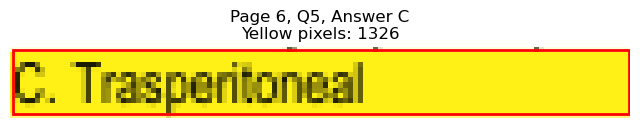

Page 6, Q5 - D: Detected box: x0=315.4, y0=354.5, x1=428.3, y1=367.2
Page 6, Q5, D: Yellow pixels: 164
Page 6, Q5, D: Total non-white pixels: 729
Page 6, Q5, D: Yellow percentage: 22.5%


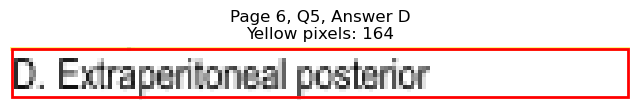


Page 6, Q5 - Selected Answer: C (based on yellow pixel count)
Page 6, Q6 - A: Detected box: x0=56.6, y0=404.9, x1=146.5, y1=417.6
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 396
Page 6, Q6, A: Yellow percentage: 0.0%


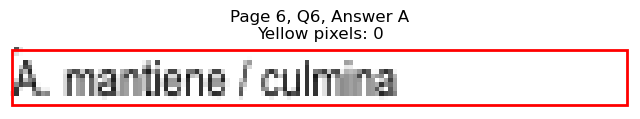

Page 6, Q6 - B: Detected box: x0=56.6, y0=417.6, x1=130.0, y1=430.3
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 332
Page 6, Q6, B: Yellow percentage: 0.0%


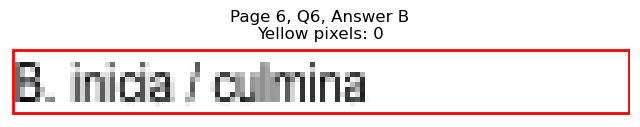

Page 6, Q6 - C: Detected box: x0=315.4, y0=404.9, x1=395.2, y1=417.6
Page 6, Q6, C: Yellow pixels: 1438
Page 6, Q6, C: Total non-white pixels: 1834
Page 6, Q6, C: Yellow percentage: 78.4%


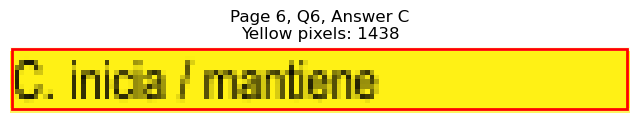

Page 6, Q6 - D: Detected box: x0=315.4, y0=417.6, x1=480.6, y1=430.3
Page 6, Q6, D: Yellow pixels: 216
Page 6, Q6, D: Total non-white pixels: 1024
Page 6, Q6, D: Yellow percentage: 21.1%


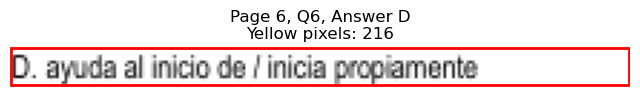


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)
Page 6, Q7 - A: Detected box: x0=56.6, y0=468.1, x1=143.1, y1=480.7
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 367
Page 6, Q7, A: Yellow percentage: 0.0%


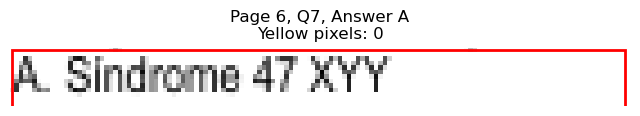

Page 6, Q7 - B: Detected box: x0=56.6, y0=480.8, x1=144.0, y1=493.4
Page 6, Q7, B: Yellow pixels: 1331
Page 6, Q7, B: Total non-white pixels: 1946
Page 6, Q7, B: Yellow percentage: 68.4%


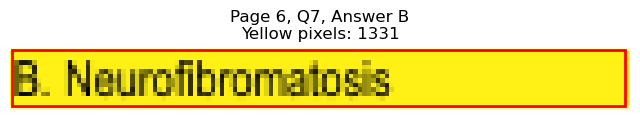

Page 6, Q7 - C: Detected box: x0=315.4, y0=468.1, x1=439.4, y1=480.7
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 602
Page 6, Q7, C: Yellow percentage: 0.0%


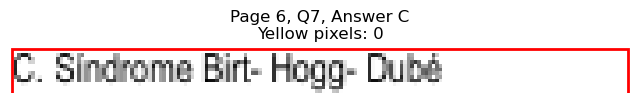

Page 6, Q7 - D: Detected box: x0=315.4, y0=480.8, x1=398.2, y1=493.4
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 389
Page 6, Q7, D: Yellow percentage: 0.0%


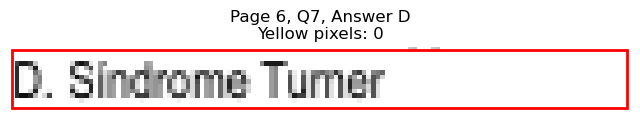


Page 6, Q7 - Selected Answer: B (based on yellow pixel count)
Page 6, Q8 - A: Detected box: x0=56.6, y0=518.6, x1=114.5, y1=531.2
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 240
Page 6, Q8, A: Yellow percentage: 0.0%


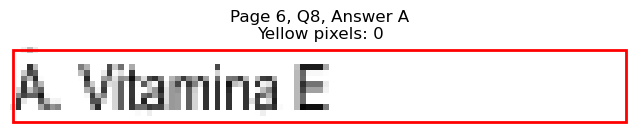

Page 6, Q8 - B: Detected box: x0=56.6, y0=531.2, x1=113.9, y1=543.8
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 259
Page 6, Q8, B: Yellow percentage: 0.0%


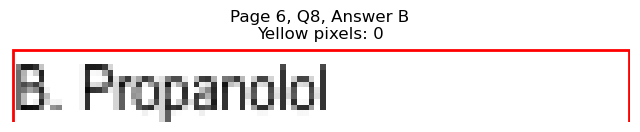

Page 6, Q8 - C: Detected box: x0=315.4, y0=518.6, x1=364.1, y1=531.2
Page 6, Q8, C: Yellow pixels: 1119
Page 6, Q8, C: Total non-white pixels: 1400
Page 6, Q8, C: Yellow percentage: 79.9%


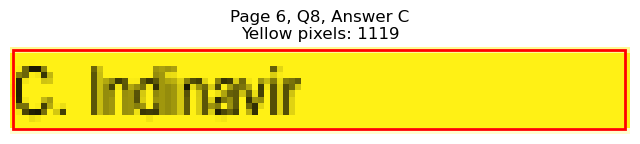

Page 6, Q8 - D: Detected box: x0=315.4, y0=531.2, x1=381.2, y1=543.8
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 426
Page 6, Q8, D: Yellow percentage: 0.0%


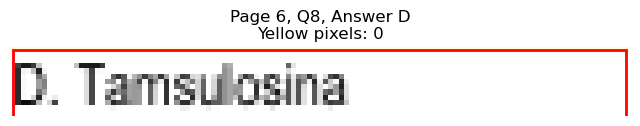


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)
Page 6, Q9 - A: Detected box: x0=56.6, y0=581.7, x1=88.8, y1=594.3
Page 6, Q9, A: Yellow pixels: 884
Page 6, Q9, A: Total non-white pixels: 1162
Page 6, Q9, A: Yellow percentage: 76.1%


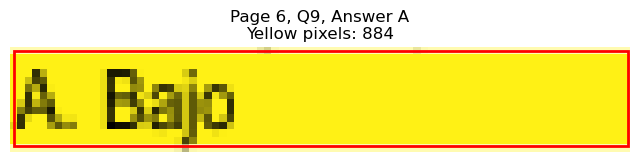

Page 6, Q9 - B: Detected box: x0=56.6, y0=594.3, x1=155.5, y1=606.9
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 622
Page 6, Q9, B: Yellow percentage: 0.0%


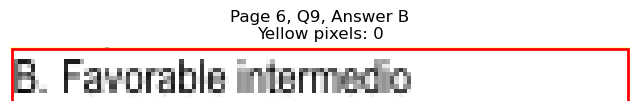

Page 6, Q9 - C: Detected box: x0=315.4, y0=581.7, x1=426.9, y1=594.3
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 558
Page 6, Q9, C: Yellow percentage: 0.0%


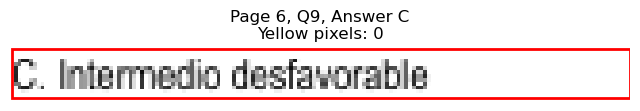

Page 6, Q9 - D: Detected box: x0=315.4, y0=594.3, x1=366.7, y1=606.9
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 240
Page 6, Q9, D: Yellow percentage: 0.0%


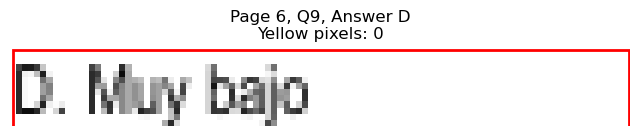


Page 6, Q9 - Selected Answer: A (based on yellow pixel count)
Page 6, Q10 - A: Detected box: x0=56.6, y0=632.2, x1=127.9, y1=644.9
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 356
Page 6, Q10, A: Yellow percentage: 0.0%


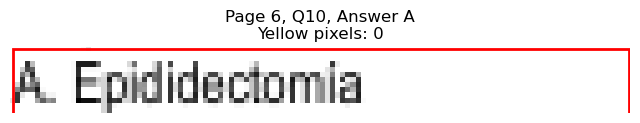

Page 6, Q10 - B: Detected box: x0=56.6, y0=644.8, x1=207.8, y1=657.5
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 757
Page 6, Q10, B: Yellow percentage: 0.0%


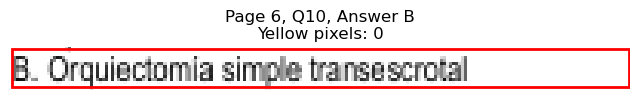

Page 6, Q10 - C: Detected box: x0=315.4, y0=632.2, x1=396.8, y1=644.9
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 525
Page 6, Q10, C: Yellow percentage: 0.0%


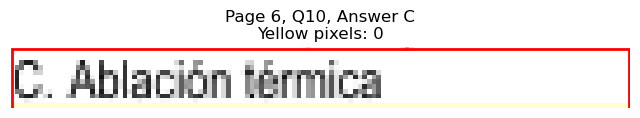

Page 6, Q10 - D: Detected box: x0=315.4, y0=644.8, x1=499.5, y1=657.5
Page 6, Q10, D: Yellow pixels: 2219
Page 6, Q10, D: Total non-white pixels: 3164
Page 6, Q10, D: Yellow percentage: 70.1%


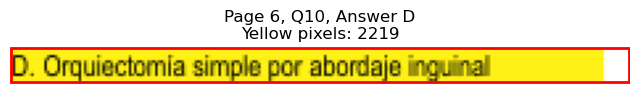


Page 6, Q10 - Selected Answer: D (based on yellow pixel count)
Page 6, Q11 - A: Detected box: x0=56.6, y0=682.6, x1=130.9, y1=695.3
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 310
Page 6, Q11, A: Yellow percentage: 0.0%


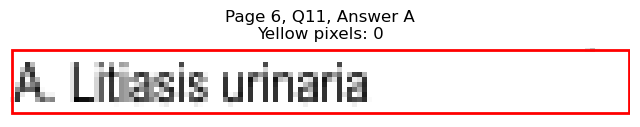

Page 6, Q11 - B: Detected box: x0=56.6, y0=695.4, x1=154.1, y1=708.0
Page 6, Q11, B: Yellow pixels: 0
Page 6, Q11, B: Total non-white pixels: 505
Page 6, Q11, B: Yellow percentage: 0.0%


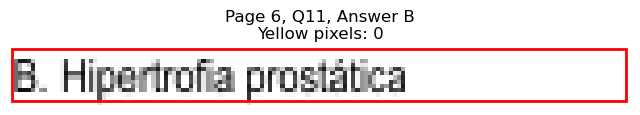

Page 6, Q11 - C: Detected box: x0=315.4, y0=682.6, x1=371.2, y1=695.3
Page 6, Q11, C: Yellow pixels: 1083
Page 6, Q11, C: Total non-white pixels: 1498
Page 6, Q11, C: Yellow percentage: 72.3%


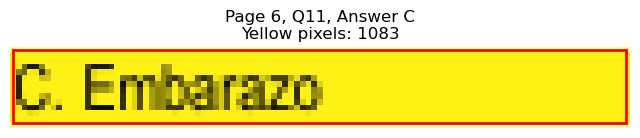

Page 6, Q11 - D: Detected box: x0=315.4, y0=695.4, x1=421.4, y1=708.0
Page 6, Q11, D: Yellow pixels: 0
Page 6, Q11, D: Total non-white pixels: 693
Page 6, Q11, D: Yellow percentage: 0.0%


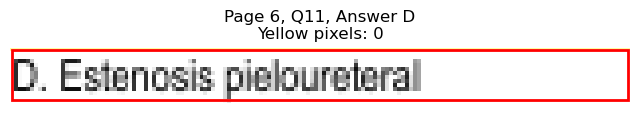


Page 6, Q11 - Selected Answer: C (based on yellow pixel count)
Page 6, Q12 - A: Detected box: x0=56.6, y0=745.8, x1=97.3, y1=758.4
Page 6, Q12, A: Yellow pixels: 0
Page 6, Q12, A: Total non-white pixels: 194
Page 6, Q12, A: Yellow percentage: 0.0%


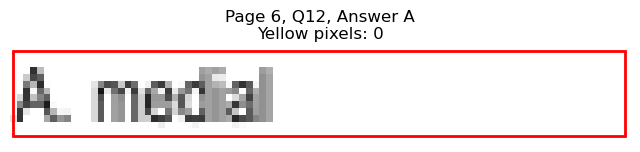

Page 6, Q12 - B: Detected box: x0=56.6, y0=758.5, x1=101.4, y1=771.1
Page 6, Q12, B: Yellow pixels: 0
Page 6, Q12, B: Total non-white pixels: 206
Page 6, Q12, B: Yellow percentage: 0.0%


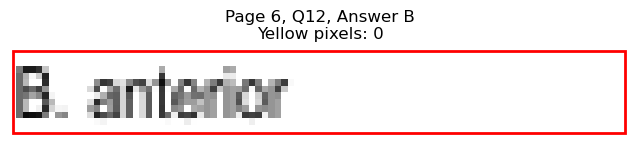

Page 6, Q12 - C: Detected box: x0=315.4, y0=745.8, x1=365.1, y1=758.4
Page 6, Q12, C: Yellow pixels: 0
Page 6, Q12, C: Total non-white pixels: 221
Page 6, Q12, C: Yellow percentage: 0.0%


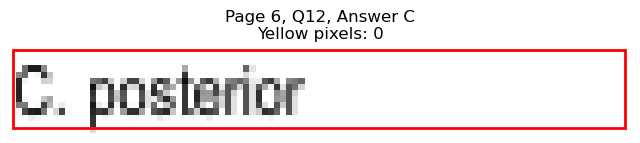

Page 6, Q12 - D: Detected box: x0=315.4, y0=758.5, x1=354.7, y1=771.1
Page 6, Q12, D: Yellow pixels: 1027
Page 6, Q12, D: Total non-white pixels: 1260
Page 6, Q12, D: Yellow percentage: 81.5%


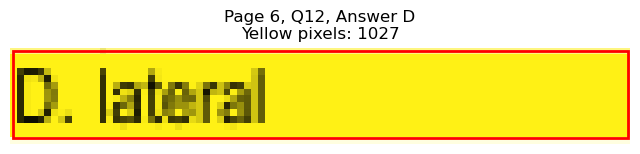


Page 6, Q12 - Selected Answer: D (based on yellow pixel count)

Page 7: Found 12 questions
Page 7, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=112.5, y1=114.7
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 277
Page 7, Q1, A: Yellow percentage: 0.0%


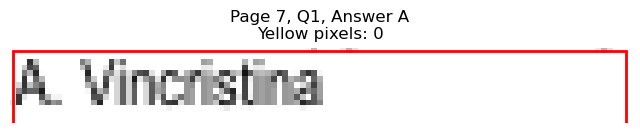

Page 7, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=126.5, y1=127.3
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 317
Page 7, Q1, B: Yellow percentage: 0.0%


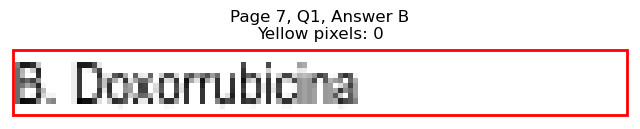

Page 7, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=389.2, y1=114.7
Page 7, Q1, C: Yellow pixels: 1347
Page 7, Q1, C: Total non-white pixels: 1625
Page 7, Q1, C: Yellow percentage: 82.9%


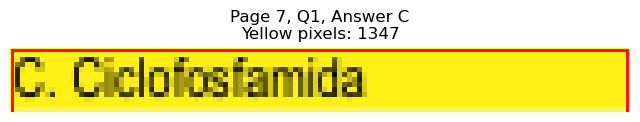

Page 7, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=377.7, y1=127.3
Page 7, Q1, D: Yellow pixels: 113
Page 7, Q1, D: Total non-white pixels: 432
Page 7, Q1, D: Yellow percentage: 26.2%


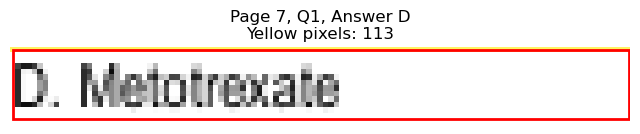


Page 7, Q1 - Selected Answer: C (based on yellow pixel count)
Page 7, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=113.9, y1=177.8
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 375
Page 7, Q2, A: Yellow percentage: 0.0%


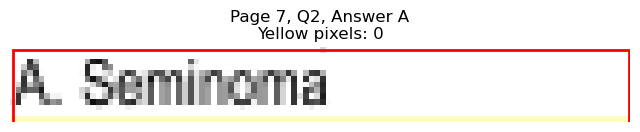

Page 7, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=144.0, y1=190.4
Page 7, Q2, B: Yellow pixels: 1347
Page 7, Q2, B: Total non-white pixels: 1946
Page 7, Q2, B: Yellow percentage: 69.2%


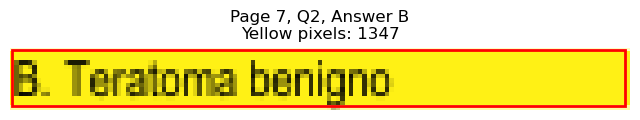

Page 7, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=420.8, y1=177.8
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 486
Page 7, Q2, C: Yellow percentage: 0.0%


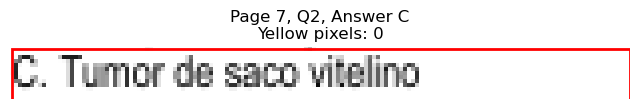

Page 7, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=440.9, y1=190.4
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 594
Page 7, Q2, D: Yellow percentage: 0.0%


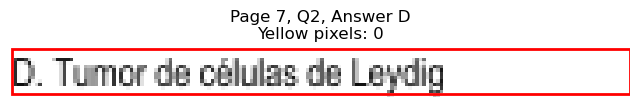


Page 7, Q2 - Selected Answer: B (based on yellow pixel count)
Page 7, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=132.0, y1=228.3
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 326
Page 7, Q3, A: Yellow percentage: 0.0%


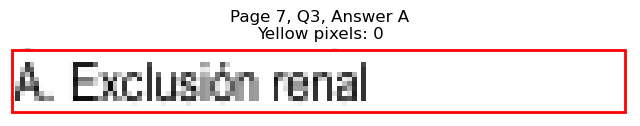

Page 7, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=97.9, y1=240.9
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 205
Page 7, Q3, B: Yellow percentage: 0.0%


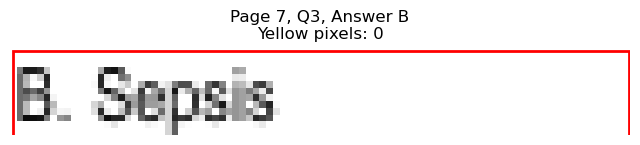

Page 7, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=364.1, y1=228.3
Page 7, Q3, C: Yellow pixels: 100
Page 7, Q3, C: Total non-white pixels: 315
Page 7, Q3, C: Yellow percentage: 31.7%


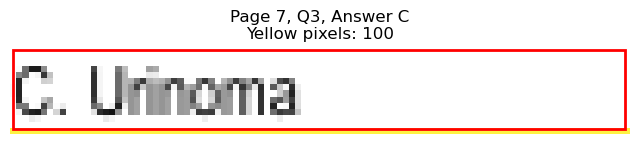

Page 7, Q3 - D: Detected box: x0=315.4, y0=228.2, x1=377.2, y1=240.9
Page 7, Q3, D: Yellow pixels: 1247
Page 7, Q3, D: Total non-white pixels: 1469
Page 7, Q3, D: Yellow percentage: 84.9%


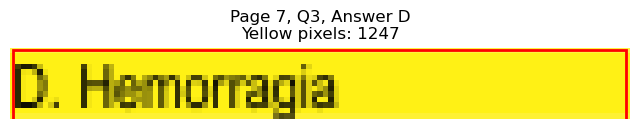


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)
Page 7, Q4 - A: Detected box: x0=56.6, y0=266.0, x1=210.3, y1=278.7
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 712
Page 7, Q4, A: Yellow percentage: 0.0%


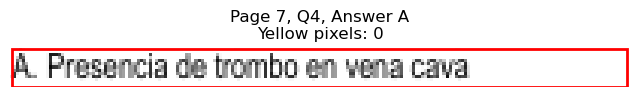

Page 7, Q4 - B: Detected box: x0=56.6, y0=278.8, x1=130.9, y1=291.4
Page 7, Q4, B: Yellow pixels: 1357
Page 7, Q4, B: Total non-white pixels: 1750
Page 7, Q4, B: Yellow percentage: 77.5%


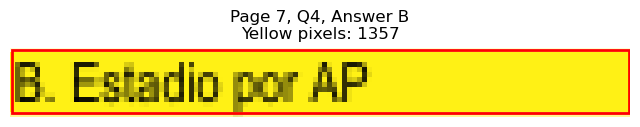

Page 7, Q4 - C: Detected box: x0=315.4, y0=266.0, x1=403.3, y1=278.7
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 401
Page 7, Q4, C: Yellow percentage: 0.0%


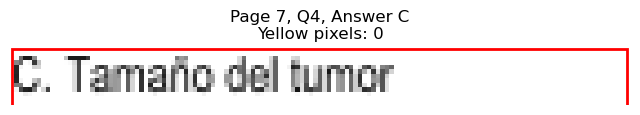

Page 7, Q4 - D: Detected box: x0=315.4, y0=278.8, x1=399.3, y1=291.4
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 395
Page 7, Q4, D: Yellow percentage: 0.0%


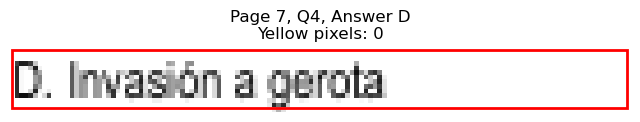


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)
Page 7, Q5 - A: Detected box: x0=56.6, y0=341.9, x1=167.1, y1=354.6
Page 7, Q5, A: Yellow pixels: 162
Page 7, Q5, A: Total non-white pixels: 687
Page 7, Q5, A: Yellow percentage: 23.6%


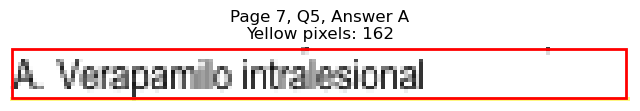

Page 7, Q5 - B: Detected box: x0=56.6, y0=354.5, x1=97.9, y1=367.2
Page 7, Q5, B: Yellow pixels: 1039
Page 7, Q5, B: Total non-white pixels: 1288
Page 7, Q5, B: Yellow percentage: 80.7%


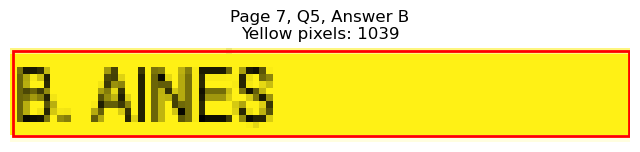

Page 7, Q5 - C: Detected box: x0=315.4, y0=341.9, x1=401.3, y1=354.6
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 386
Page 7, Q5, C: Yellow percentage: 0.0%


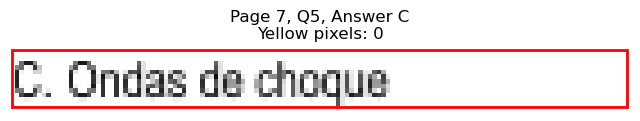

Page 7, Q5 - D: Detected box: x0=315.4, y0=354.5, x1=510.1, y1=367.2
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 969
Page 7, Q5, D: Yellow percentage: 0.0%


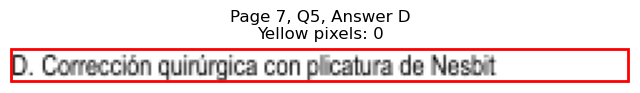


Page 7, Q5 - Selected Answer: B (based on yellow pixel count)
Page 7, Q6 - A: Detected box: x0=56.6, y0=404.9, x1=127.9, y1=417.6
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 350
Page 7, Q6, A: Yellow percentage: 0.0%


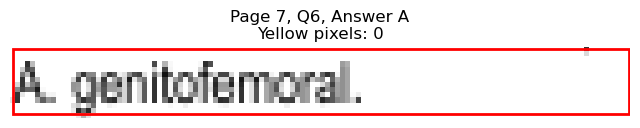

Page 7, Q6 - B: Detected box: x0=56.6, y0=417.6, x1=115.5, y1=430.3
Page 7, Q6, B: Yellow pixels: 1115
Page 7, Q6, B: Total non-white pixels: 1540
Page 7, Q6, B: Yellow percentage: 72.4%


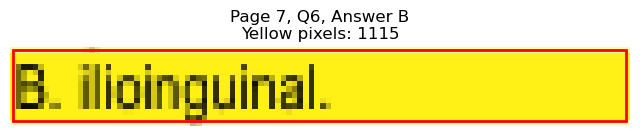

Page 7, Q6 - C: Detected box: x0=315.4, y0=404.9, x1=367.7, y1=417.6
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 215
Page 7, Q6, C: Yellow percentage: 0.0%


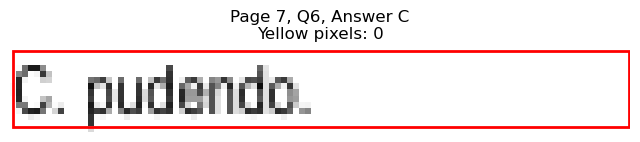

Page 7, Q6 - D: Detected box: x0=315.4, y0=417.6, x1=371.2, y1=430.3
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 254
Page 7, Q6, D: Yellow percentage: 0.0%


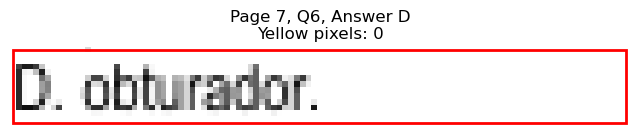


Page 7, Q6 - Selected Answer: B (based on yellow pixel count)
Page 7, Q7 - A: Detected box: x0=56.6, y0=455.5, x1=123.5, y1=468.1
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 321
Page 7, Q7, A: Yellow percentage: 0.0%


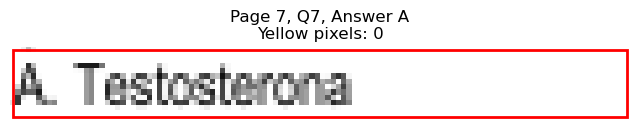

Page 7, Q7 - B: Detected box: x0=56.6, y0=468.1, x1=110.9, y1=480.7
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 251
Page 7, Q7, B: Yellow percentage: 0.0%


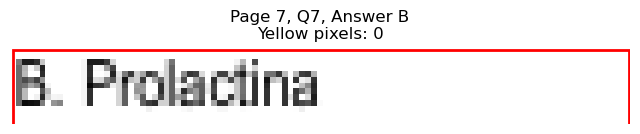

Page 7, Q7 - C: Detected box: x0=315.4, y0=455.5, x1=348.1, y1=468.1
Page 7, Q7, C: Yellow pixels: 84
Page 7, Q7, C: Total non-white pixels: 220
Page 7, Q7, C: Yellow percentage: 38.2%


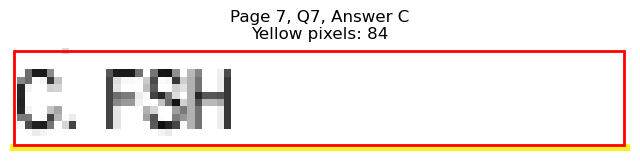

Page 7, Q7 - D: Detected box: x0=315.4, y0=468.1, x1=408.3, y1=480.7
Page 7, Q7, D: Yellow pixels: 1496
Page 7, Q7, D: Total non-white pixels: 1872
Page 7, Q7, D: Yellow percentage: 79.9%


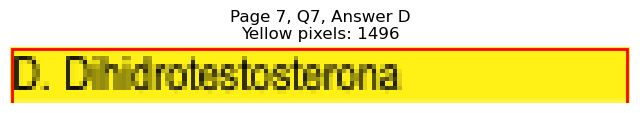


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)
Page 7, Q8 - A: Detected box: x0=56.6, y0=506.0, x1=143.5, y1=518.6
Page 7, Q8, A: Yellow pixels: 1451
Page 7, Q8, A: Total non-white pixels: 1932
Page 7, Q8, A: Yellow percentage: 75.1%


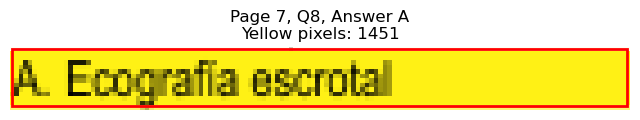

Page 7, Q8 - B: Detected box: x0=56.6, y0=518.6, x1=116.9, y1=531.2
Page 7, Q8, B: Yellow pixels: 110
Page 7, Q8, B: Total non-white pixels: 390
Page 7, Q8, B: Yellow percentage: 28.2%


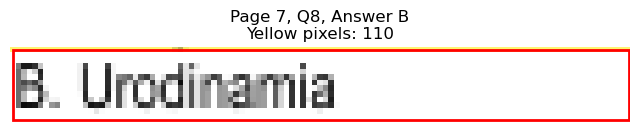

Page 7, Q8 - C: Detected box: x0=315.4, y0=506.0, x1=417.3, y1=518.6
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 499
Page 7, Q8, C: Yellow percentage: 0.0%


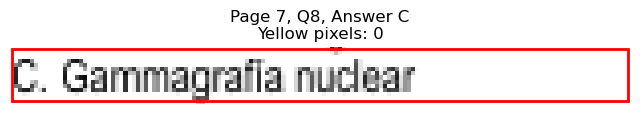

Page 7, Q8 - D: Detected box: x0=315.4, y0=518.6, x1=376.1, y1=531.2
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 282
Page 7, Q8, D: Yellow percentage: 0.0%


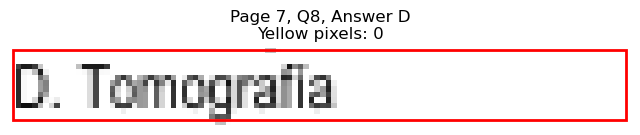


Page 7, Q8 - Selected Answer: A (based on yellow pixel count)
Page 7, Q9 - A: Detected box: x0=56.6, y0=556.5, x1=115.0, y1=569.1
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 266
Page 7, Q9, A: Yellow percentage: 0.0%


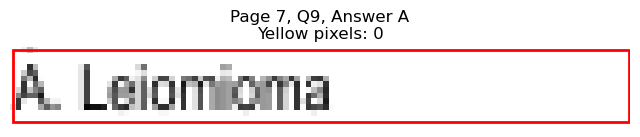

Page 7, Q9 - B: Detected box: x0=56.6, y0=569.1, x1=135.0, y1=581.7
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 406
Page 7, Q9, B: Yellow percentage: 0.0%


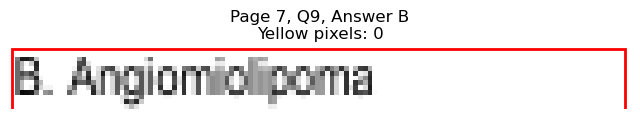

Page 7, Q9 - C: Detected box: x0=315.4, y0=556.5, x1=378.2, y1=569.1
Page 7, Q9, C: Yellow pixels: 1270
Page 7, Q9, C: Total non-white pixels: 1596
Page 7, Q9, C: Yellow percentage: 79.6%


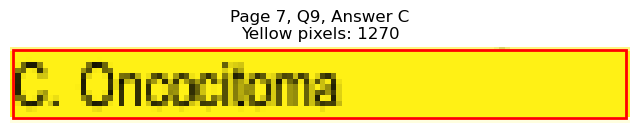

Page 7, Q9 - D: Detected box: x0=315.4, y0=569.1, x1=418.3, y1=581.7
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 635
Page 7, Q9, D: Yellow percentage: 0.0%


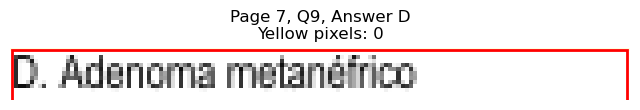


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)
Page 7, Q10 - A: Detected box: x0=56.6, y0=606.9, x1=148.6, y1=619.5
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 434
Page 7, Q10, A: Yellow percentage: 0.0%


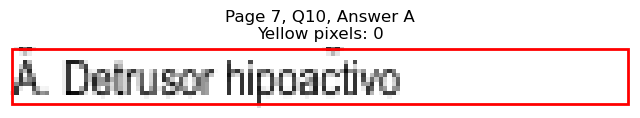

Page 7, Q10 - B: Detected box: x0=56.6, y0=619.6, x1=198.7, y1=632.3
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 745
Page 7, Q10, B: Yellow percentage: 0.0%


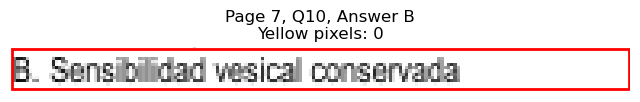

Page 7, Q10 - C: Detected box: x0=315.4, y0=606.9, x1=422.8, y1=619.5
Page 7, Q10, C: Yellow pixels: 1632
Page 7, Q10, C: Total non-white pixels: 2212
Page 7, Q10, C: Yellow percentage: 73.8%


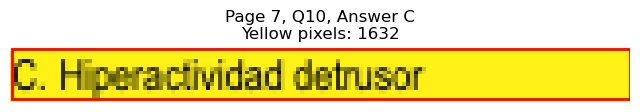

Page 7, Q10 - D: Detected box: x0=315.4, y0=619.6, x1=470.0, y1=632.3
Page 7, Q10, D: Yellow pixels: 206
Page 7, Q10, D: Total non-white pixels: 991
Page 7, Q10, D: Yellow percentage: 20.8%


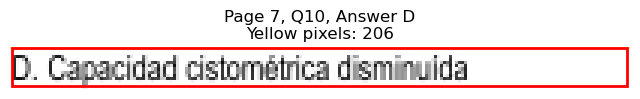


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)
Page 7, Q11 - A: Detected box: x0=56.6, y0=670.0, x1=222.3, y1=682.7
Page 7, Q11, A: Yellow pixels: 2223
Page 7, Q11, A: Total non-white pixels: 2821
Page 7, Q11, A: Yellow percentage: 78.8%


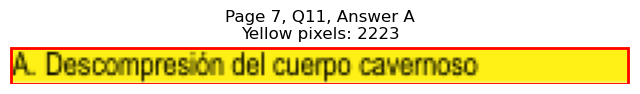

Page 7, Q11 - B: Detected box: x0=56.6, y0=682.6, x1=190.2, y1=695.3
Page 7, Q11, B: Yellow pixels: 185
Page 7, Q11, B: Total non-white pixels: 842
Page 7, Q11, B: Yellow percentage: 22.0%


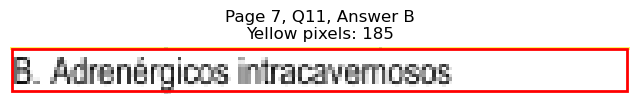

Page 7, Q11 - C: Detected box: x0=315.4, y0=670.0, x1=397.7, y1=682.7
Page 7, Q11, C: Yellow pixels: 0
Page 7, Q11, C: Total non-white pixels: 352
Page 7, Q11, C: Yellow percentage: 0.0%


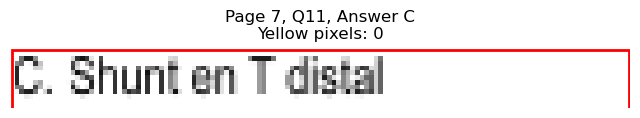

Page 7, Q11 - D: Detected box: x0=315.4, y0=682.6, x1=429.9, y1=695.3
Page 7, Q11, D: Yellow pixels: 0
Page 7, Q11, D: Total non-white pixels: 557
Page 7, Q11, D: Yellow percentage: 0.0%


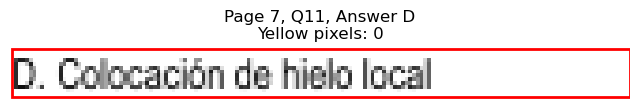


Page 7, Q11 - Selected Answer: A (based on yellow pixel count)
Page 7, Q12 - A: Detected box: x0=56.6, y0=733.2, x1=127.5, y1=745.8
Page 7, Q12, A: Yellow pixels: 1
Page 7, Q12, A: Total non-white pixels: 431
Page 7, Q12, A: Yellow percentage: 0.2%


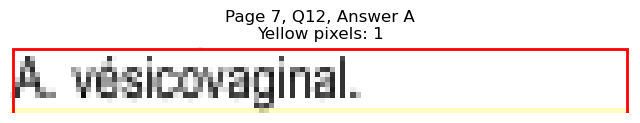

Page 7, Q12 - B: Detected box: x0=56.6, y0=745.8, x1=130.5, y1=758.4
Page 7, Q12, B: Yellow pixels: 1345
Page 7, Q12, B: Total non-white pixels: 1750
Page 7, Q12, B: Yellow percentage: 76.9%


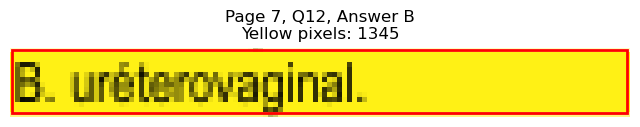

Page 7, Q12 - C: Detected box: x0=315.4, y0=733.2, x1=384.8, y1=745.8
Page 7, Q12, C: Yellow pixels: 0
Page 7, Q12, C: Total non-white pixels: 322
Page 7, Q12, C: Yellow percentage: 0.0%


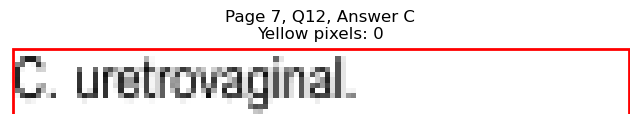

Page 7, Q12 - D: Detected box: x0=315.4, y0=745.8, x1=381.2, y1=758.4
Page 7, Q12, D: Yellow pixels: 0
Page 7, Q12, D: Total non-white pixels: 324
Page 7, Q12, D: Yellow percentage: 0.0%


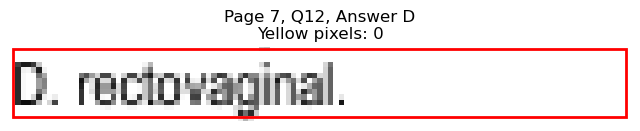


Page 7, Q12 - Selected Answer: B (based on yellow pixel count)

Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=105.4, y1=127.3
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 210
Page 8, Q1, A: Yellow percentage: 0.0%


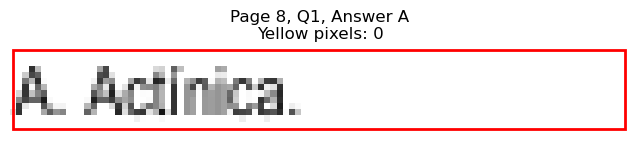

Page 8, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=124.9, y1=139.9
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 309
Page 8, Q1, B: Yellow percentage: 0.0%


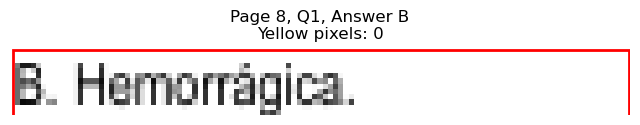

Page 8, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=363.7, y1=127.3
Page 8, Q1, C: Yellow pixels: 99
Page 8, Q1, C: Total non-white pixels: 307
Page 8, Q1, C: Yellow percentage: 32.2%


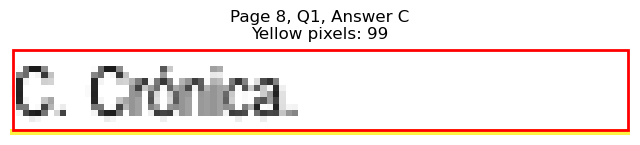

Page 8, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=370.6, y1=139.9
Page 8, Q1, D: Yellow pixels: 1163
Page 8, Q1, D: Total non-white pixels: 1378
Page 8, Q1, D: Yellow percentage: 84.4%


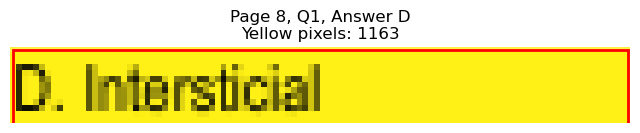


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)
Page 8, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=75.9, y1=203.0
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 61
Page 8, Q2, A: Yellow percentage: 0.0%


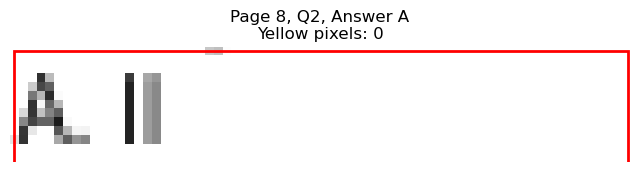

Page 8, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=73.3, y1=215.6
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 50
Page 8, Q2, B: Yellow percentage: 0.0%


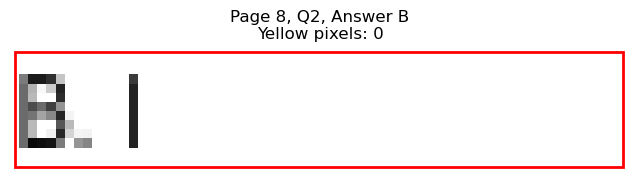

Page 8, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=337.6, y1=203.0
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 157
Page 8, Q2, C: Yellow percentage: 0.0%


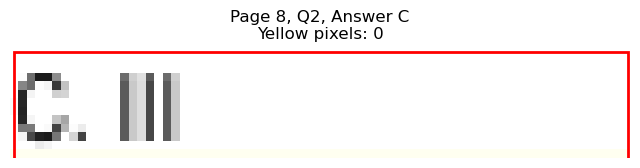

Page 8, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=340.6, y1=215.6
Page 8, Q2, D: Yellow pixels: 916
Page 8, Q2, D: Total non-white pixels: 1064
Page 8, Q2, D: Yellow percentage: 86.1%


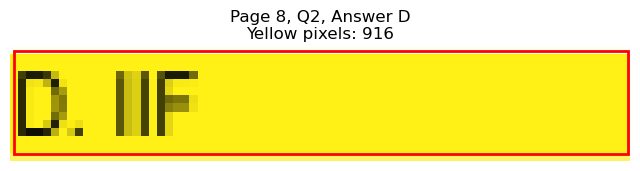


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)
Page 8, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=127.5, y1=266.1
Page 8, Q3, A: Yellow pixels: 1333
Page 8, Q3, A: Total non-white pixels: 1708
Page 8, Q3, A: Yellow percentage: 78.0%


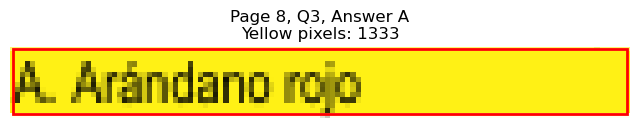

Page 8, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=125.4, y1=278.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 448
Page 8, Q3, B: Yellow percentage: 0.0%


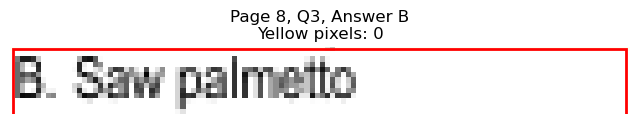

Page 8, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=402.3, y1=266.1
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 436
Page 8, Q3, C: Yellow percentage: 0.0%


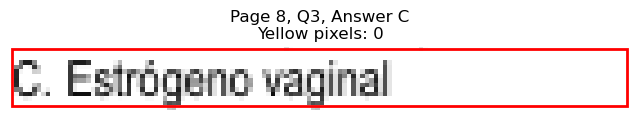

Page 8, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=374.2, y1=278.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 263
Page 8, Q3, D: Yellow percentage: 0.0%


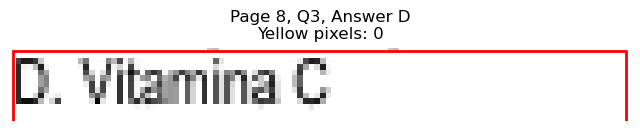


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)
Page 8, Q4 - A: Detected box: x0=56.6, y0=329.2, x1=247.8, y1=341.8
Page 8, Q4, A: Yellow pixels: 2200
Page 8, Q4, A: Total non-white pixels: 2938
Page 8, Q4, A: Yellow percentage: 74.9%


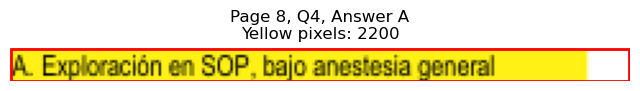

Page 8, Q4 - B: Detected box: x0=56.6, y0=341.9, x1=192.7, y1=354.6
Page 8, Q4, B: Yellow pixels: 179
Page 8, Q4, B: Total non-white pixels: 853
Page 8, Q4, B: Yellow percentage: 21.0%


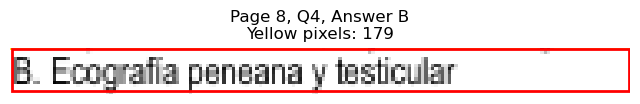

Page 8, Q4 - C: Detected box: x0=315.4, y0=329.2, x1=442.4, y1=341.8
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 606
Page 8, Q4, C: Yellow percentage: 0.0%


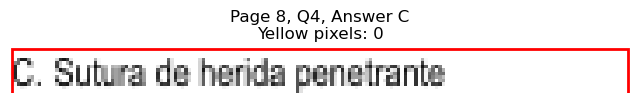

Page 8, Q4 - D: Detected box: x0=315.4, y0=341.9, x1=380.7, y1=354.6
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 306
Page 8, Q4, D: Yellow percentage: 0.0%


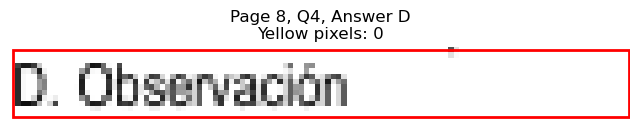


Page 8, Q4 - Selected Answer: A (based on yellow pixel count)
Page 8, Q5 - A: Detected box: x0=56.6, y0=392.3, x1=111.4, y1=405.0
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 379
Page 8, Q5, A: Yellow percentage: 0.0%


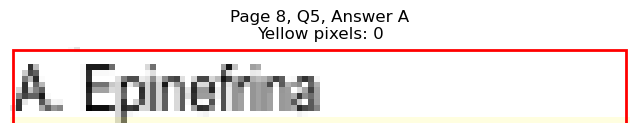

Page 8, Q5 - B: Detected box: x0=56.6, y0=404.9, x1=112.9, y1=417.6
Page 8, Q5, B: Yellow pixels: 1175
Page 8, Q5, B: Total non-white pixels: 1498
Page 8, Q5, B: Yellow percentage: 78.4%


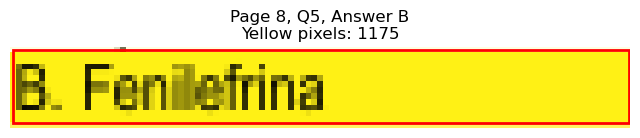

Page 8, Q5 - C: Detected box: x0=315.4, y0=392.3, x1=363.7, y1=405.0
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 229
Page 8, Q5, C: Yellow percentage: 0.0%


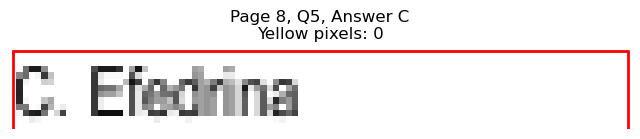

Page 8, Q5 - D: Detected box: x0=315.4, y0=404.9, x1=365.1, y1=417.6
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 242
Page 8, Q5, D: Yellow percentage: 0.0%


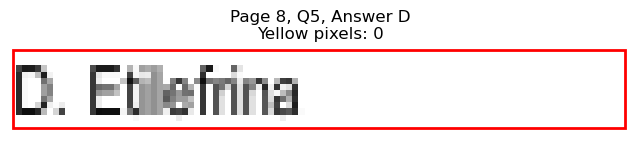


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)
Page 8, Q6 - A: Detected box: x0=56.6, y0=442.8, x1=95.4, y1=455.5
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 204
Page 8, Q6, A: Yellow percentage: 0.0%


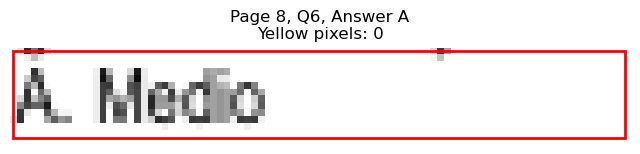

Page 8, Q6 - B: Detected box: x0=56.6, y0=455.5, x1=104.9, y1=468.1
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 220
Page 8, Q6, B: Yellow percentage: 0.0%


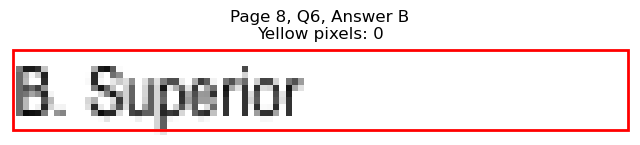

Page 8, Q6 - C: Detected box: x0=315.4, y0=442.8, x1=370.6, y1=455.5
Page 8, Q6, C: Yellow pixels: 106
Page 8, Q6, C: Total non-white pixels: 355
Page 8, Q6, C: Yellow percentage: 29.9%


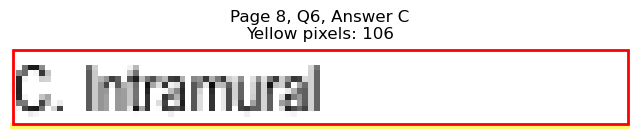

Page 8, Q6 - D: Detected box: x0=315.4, y0=455.5, x1=352.6, y1=468.1
Page 8, Q6, D: Yellow pixels: 1003
Page 8, Q6, D: Total non-white pixels: 1232
Page 8, Q6, D: Yellow percentage: 81.4%


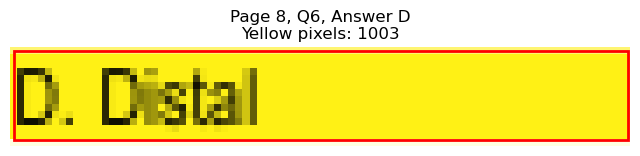


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)
Page 8, Q7 - A: Detected box: x0=56.6, y0=493.4, x1=91.8, y1=506.0
Page 8, Q7, A: Yellow pixels: 86
Page 8, Q7, A: Total non-white pixels: 323
Page 8, Q7, A: Yellow percentage: 26.6%


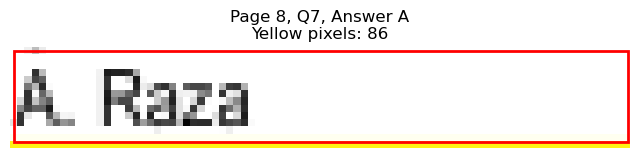

Page 8, Q7 - B: Detected box: x0=56.6, y0=506.0, x1=91.9, y1=518.6
Page 8, Q7, B: Yellow pixels: 987
Page 8, Q7, B: Total non-white pixels: 1204
Page 8, Q7, B: Yellow percentage: 82.0%


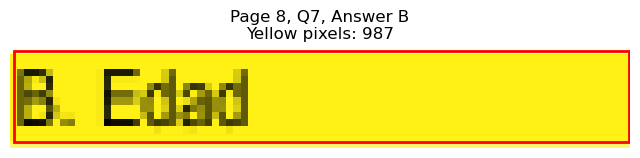

Page 8, Q7 - C: Detected box: x0=315.4, y0=493.4, x1=361.1, y1=506.0
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 192
Page 8, Q7, C: Yellow percentage: 0.0%


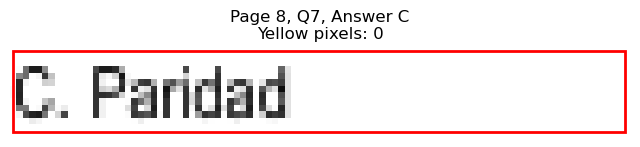

Page 8, Q7 - D: Detected box: x0=315.4, y0=506.0, x1=368.7, y1=518.6
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 257
Page 8, Q7, D: Yellow percentage: 0.0%


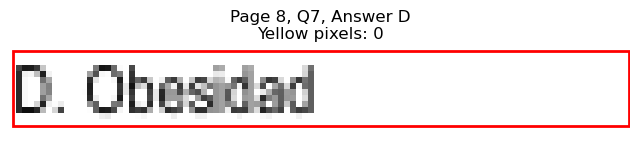


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)
Page 8, Q8 - A: Detected box: x0=56.6, y0=543.8, x1=102.3, y1=556.4
Page 8, Q8, A: Yellow pixels: 1152
Page 8, Q8, A: Total non-white pixels: 1358
Page 8, Q8, A: Yellow percentage: 84.8%


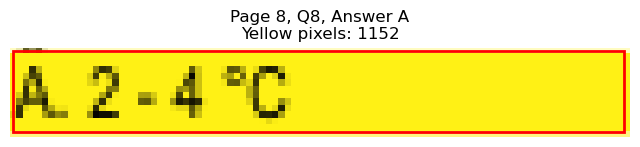

Page 8, Q8 - B: Detected box: x0=56.6, y0=556.5, x1=102.3, y1=569.1
Page 8, Q8, B: Yellow pixels: 97
Page 8, Q8, B: Total non-white pixels: 248
Page 8, Q8, B: Yellow percentage: 39.1%


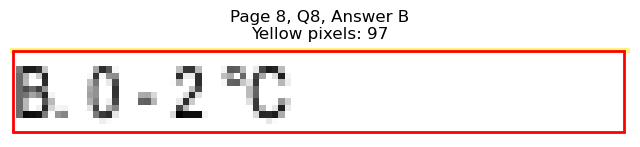

Page 8, Q8 - C: Detected box: x0=315.4, y0=543.8, x1=361.5, y1=556.4
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 149
Page 8, Q8, C: Yellow percentage: 0.0%


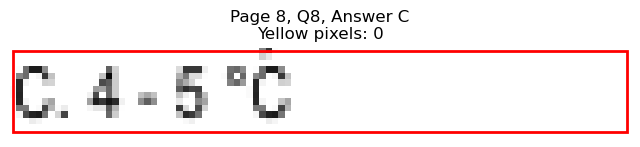

Page 8, Q8 - D: Detected box: x0=315.4, y0=556.5, x1=361.5, y1=569.1
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 126
Page 8, Q8, D: Yellow percentage: 0.0%


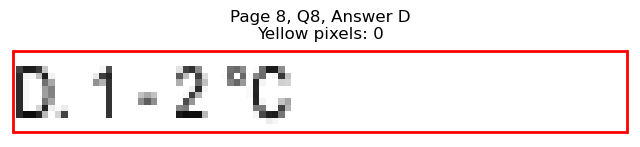


Page 8, Q8 - Selected Answer: A (based on yellow pixel count)
Page 8, Q9 - A: Detected box: x0=56.6, y0=619.6, x1=171.6, y1=632.3
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 564
Page 8, Q9, A: Yellow percentage: 0.0%


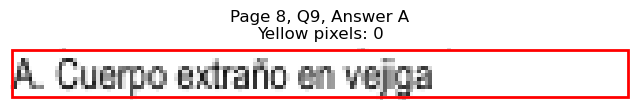

Page 8, Q9 - B: Detected box: x0=56.6, y0=632.2, x1=157.1, y1=644.9
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 459
Page 8, Q9, B: Yellow percentage: 0.0%


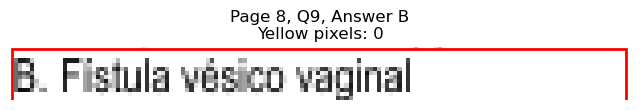

Page 8, Q9 - C: Detected box: x0=315.4, y0=619.6, x1=414.3, y1=632.3
Page 8, Q9, C: Yellow pixels: 150
Page 8, Q9, C: Total non-white pixels: 619
Page 8, Q9, C: Yellow percentage: 24.2%


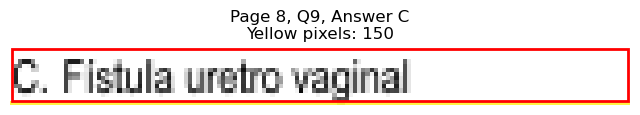

Page 8, Q9 - D: Detected box: x0=315.4, y0=632.2, x1=440.9, y1=644.9
Page 8, Q9, D: Yellow pixels: 1847
Page 8, Q9, D: Total non-white pixels: 2288
Page 8, Q9, D: Yellow percentage: 80.7%


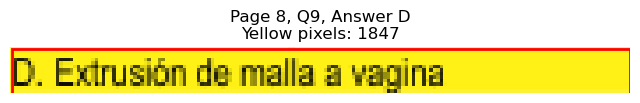


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)
Page 8, Q10 - A: Detected box: x0=56.6, y0=670.0, x1=109.9, y1=682.7
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 248
Page 8, Q10, A: Yellow percentage: 0.0%


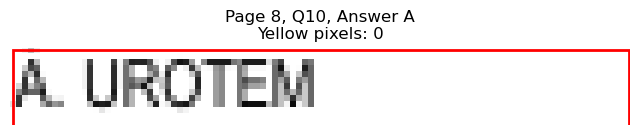

Page 8, Q10 - B: Detected box: x0=56.6, y0=682.6, x1=117.5, y1=695.3
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 310
Page 8, Q10, B: Yellow percentage: 0.0%


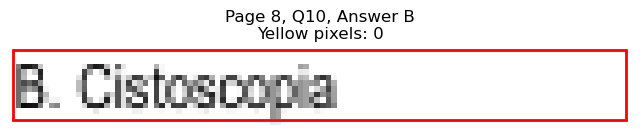

Page 8, Q10 - C: Detected box: x0=315.4, y0=670.0, x1=422.3, y1=682.7
Page 8, Q10, C: Yellow pixels: 1657
Page 8, Q10, C: Total non-white pixels: 2054
Page 8, Q10, C: Yellow percentage: 80.7%


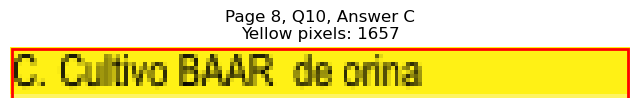

Page 8, Q10 - D: Detected box: x0=315.4, y0=682.6, x1=371.7, y1=695.3
Page 8, Q10, D: Yellow pixels: 107
Page 8, Q10, D: Total non-white pixels: 359
Page 8, Q10, D: Yellow percentage: 29.8%


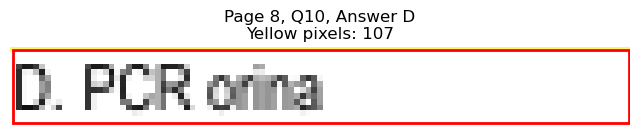


Page 8, Q10 - Selected Answer: C (based on yellow pixel count)
Page 8, Q11 - A: Detected box: x0=56.6, y0=733.2, x1=115.5, y1=745.8
Page 8, Q11, A: Yellow pixels: 0
Page 8, Q11, A: Total non-white pixels: 270
Page 8, Q11, A: Yellow percentage: 0.0%


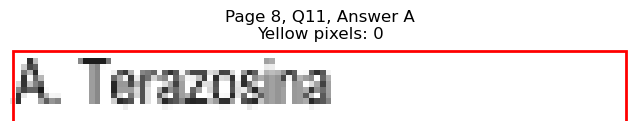

Page 8, Q11 - B: Detected box: x0=56.6, y0=745.8, x1=118.0, y1=758.4
Page 8, Q11, B: Yellow pixels: 0
Page 8, Q11, B: Total non-white pixels: 274
Page 8, Q11, B: Yellow percentage: 0.0%


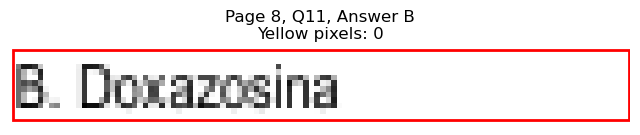

Page 8, Q11 - C: Detected box: x0=315.4, y0=733.2, x1=371.7, y1=745.8
Page 8, Q11, C: Yellow pixels: 1191
Page 8, Q11, C: Total non-white pixels: 1391
Page 8, Q11, C: Yellow percentage: 85.6%


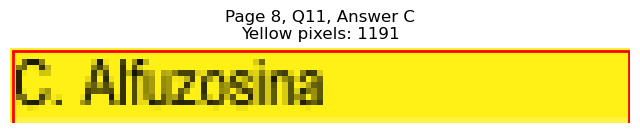

Page 8, Q11 - D: Detected box: x0=315.4, y0=745.8, x1=370.1, y1=758.4
Page 8, Q11, D: Yellow pixels: 106
Page 8, Q11, D: Total non-white pixels: 354
Page 8, Q11, D: Yellow percentage: 29.9%


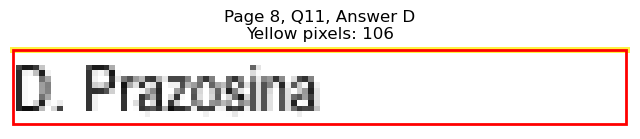


Page 8, Q11 - Selected Answer: C (based on yellow pixel count)

Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=286.0, y1=102.1
Page 9, Q1, A: Yellow pixels: 281
Page 9, Q1, A: Total non-white pixels: 1443
Page 9, Q1, A: Yellow percentage: 19.5%


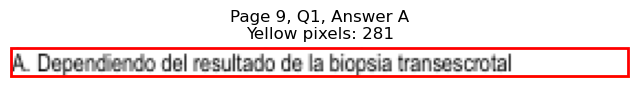

Page 9, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=207.0, y1=114.7
Page 9, Q1, B: Yellow pixels: 2114
Page 9, Q1, B: Total non-white pixels: 2626
Page 9, Q1, B: Yellow percentage: 80.5%


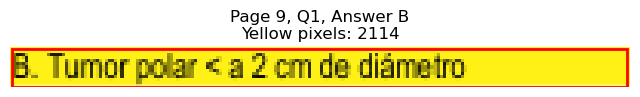

Page 9, Q1 - C: Detected box: x0=56.6, y0=114.6, x1=249.4, y1=127.3
Page 9, Q1, C: Yellow pixels: 244
Page 9, Q1, C: Total non-white pixels: 1108
Page 9, Q1, C: Yellow percentage: 22.0%


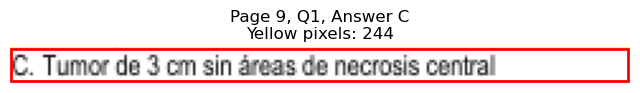

Page 9, Q1 - D: Detected box: x0=56.6, y0=127.2, x1=106.9, y1=139.9
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 230
Page 9, Q1, D: Yellow percentage: 0.0%


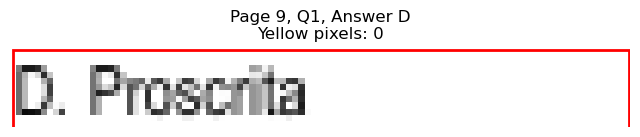


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)
Page 9, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=88.8, y1=177.8
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 114
Page 9, Q2, A: Yellow percentage: 0.0%


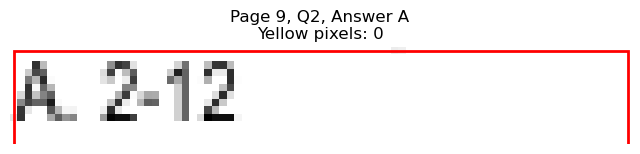

Page 9, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=88.8, y1=190.4
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 129
Page 9, Q2, B: Yellow percentage: 0.0%


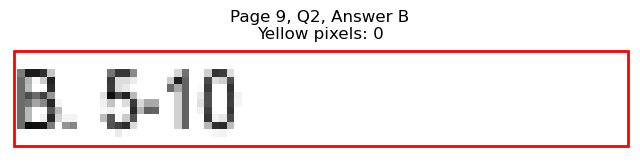

Page 9, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=353.1, y1=177.8
Page 9, Q2, C: Yellow pixels: 1050
Page 9, Q2, C: Total non-white pixels: 1157
Page 9, Q2, C: Yellow percentage: 90.8%


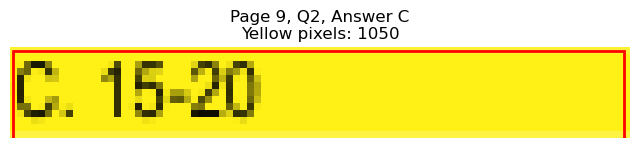

Page 9, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=348.1, y1=190.4
Page 9, Q2, D: Yellow pixels: 84
Page 9, Q2, D: Total non-white pixels: 206
Page 9, Q2, D: Yellow percentage: 40.8%


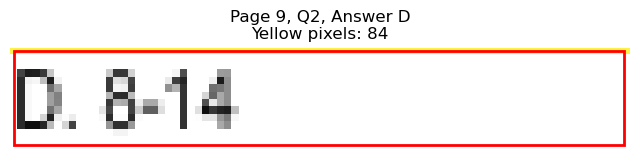


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)
Page 9, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=98.9, y1=228.3
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 135
Page 9, Q3, A: Yellow percentage: 0.0%


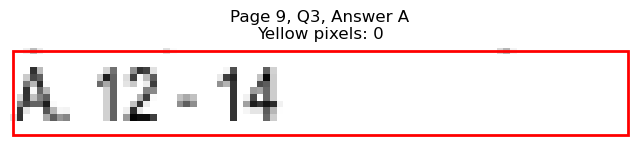

Page 9, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=93.9, y1=240.9
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 126
Page 9, Q3, B: Yellow percentage: 0.0%


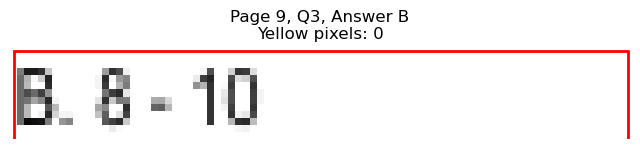

Page 9, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=358.1, y1=228.3
Page 9, Q3, C: Yellow pixels: 1034
Page 9, Q3, C: Total non-white pixels: 1316
Page 9, Q3, C: Yellow percentage: 78.6%


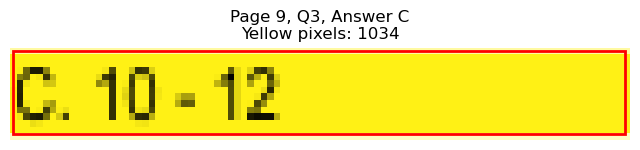

Page 9, Q3 - D: Detected box: x0=315.4, y0=228.2, x1=355.6, y1=240.9
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 233
Page 9, Q3, D: Yellow percentage: 0.0%


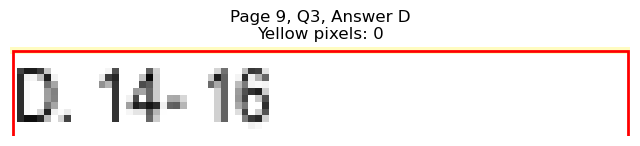


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)
Page 9, Q4 - A: Detected box: x0=56.6, y0=278.8, x1=248.3, y1=291.4
Page 9, Q4, A: Yellow pixels: 2329
Page 9, Q4, A: Total non-white pixels: 3164
Page 9, Q4, A: Yellow percentage: 73.6%


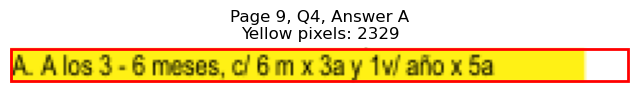

Page 9, Q4 - B: Detected box: x0=56.6, y0=291.4, x1=193.2, y1=304.0
Page 9, Q4, B: Yellow pixels: 187
Page 9, Q4, B: Total non-white pixels: 743
Page 9, Q4, B: Yellow percentage: 25.2%


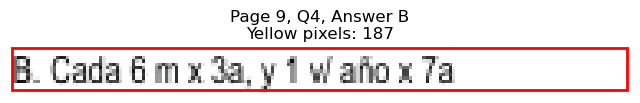

Page 9, Q4 - C: Detected box: x0=315.4, y0=278.8, x1=452.5, y1=291.4
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 560
Page 9, Q4, C: Yellow percentage: 0.0%


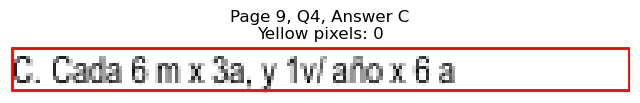

Page 9, Q4 - D: Detected box: x0=315.4, y0=291.4, x1=393.8, y1=304.0
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 326
Page 9, Q4, D: Yellow percentage: 0.0%


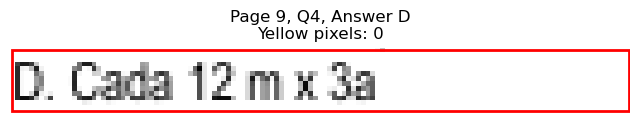


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)
Page 9, Q5 - A: Detected box: x0=56.6, y0=329.2, x1=116.4, y1=341.8
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 296
Page 9, Q5, A: Yellow percentage: 0.0%


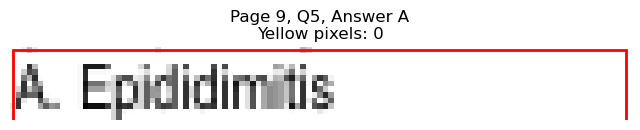

Page 9, Q5 - B: Detected box: x0=56.6, y0=341.9, x1=139.5, y1=354.6
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 422
Page 9, Q5, B: Yellow percentage: 0.0%


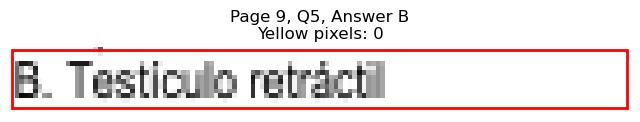

Page 9, Q5 - C: Detected box: x0=315.4, y0=329.2, x1=372.2, y1=341.8
Page 9, Q5, C: Yellow pixels: 1216
Page 9, Q5, C: Total non-white pixels: 1404
Page 9, Q5, C: Yellow percentage: 86.6%


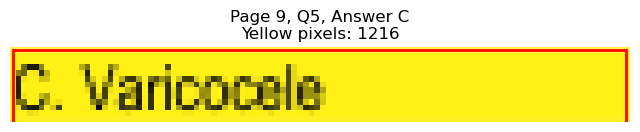

Page 9, Q5 - D: Detected box: x0=315.4, y0=341.9, x1=368.2, y1=354.6
Page 9, Q5, D: Yellow pixels: 104
Page 9, Q5, D: Total non-white pixels: 363
Page 9, Q5, D: Yellow percentage: 28.7%


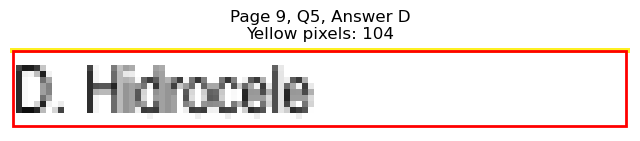


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)
Page 9, Q6 - A: Detected box: x0=56.6, y0=379.7, x1=115.5, y1=392.4
Page 9, Q6, A: Yellow pixels: 110
Page 9, Q6, A: Total non-white pixels: 386
Page 9, Q6, A: Yellow percentage: 28.5%


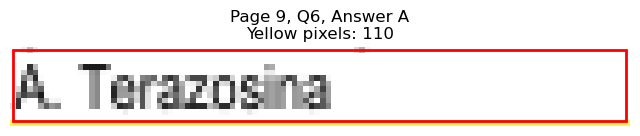

Page 9, Q6 - B: Detected box: x0=56.6, y0=392.3, x1=121.9, y1=405.0
Page 9, Q6, B: Yellow pixels: 1265
Page 9, Q6, B: Total non-white pixels: 1508
Page 9, Q6, B: Yellow percentage: 83.9%


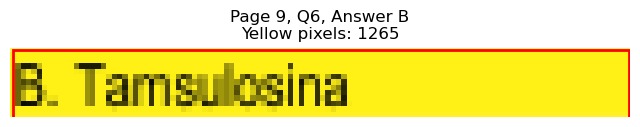

Page 9, Q6 - C: Detected box: x0=315.4, y0=379.7, x1=376.1, y1=392.4
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 300
Page 9, Q6, C: Yellow percentage: 0.0%


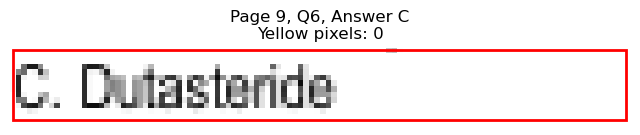

Page 9, Q6 - D: Detected box: x0=315.4, y0=392.3, x1=369.2, y1=405.0
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 263
Page 9, Q6, D: Yellow percentage: 0.0%


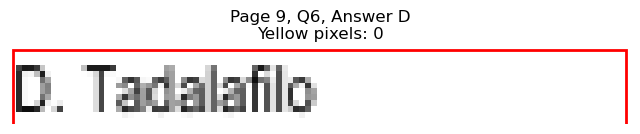


Page 9, Q6 - Selected Answer: B (based on yellow pixel count)
Page 9, Q7 - A: Detected box: x0=56.6, y0=430.2, x1=158.1, y1=442.9
Page 9, Q7, A: Yellow pixels: 1618
Page 9, Q7, A: Total non-white pixels: 1989
Page 9, Q7, A: Yellow percentage: 81.3%


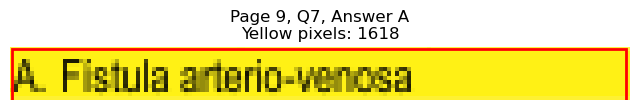

Page 9, Q7 - B: Detected box: x0=56.6, y0=442.8, x1=134.1, y1=455.5
Page 9, Q7, B: Yellow pixels: 129
Page 9, Q7, B: Total non-white pixels: 478
Page 9, Q7, B: Yellow percentage: 27.0%


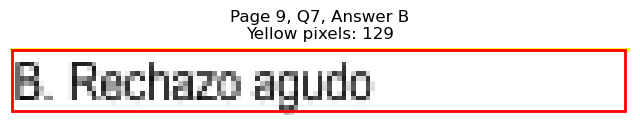

Page 9, Q7 - C: Detected box: x0=315.4, y0=430.2, x1=499.7, y1=442.9
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 895
Page 9, Q7, C: Yellow percentage: 0.0%


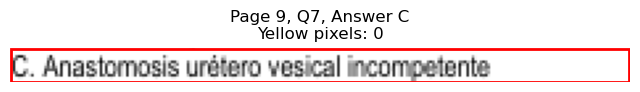

Page 9, Q7 - D: Detected box: x0=315.4, y0=442.8, x1=418.3, y1=455.5
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 521
Page 9, Q7, D: Yellow percentage: 0.0%


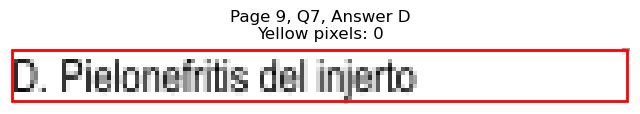


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)
Page 9, Q8 - A: Detected box: x0=56.6, y0=480.8, x1=154.1, y1=493.4
Page 9, Q8, A: Yellow pixels: 149
Page 9, Q8, A: Total non-white pixels: 612
Page 9, Q8, A: Yellow percentage: 24.3%


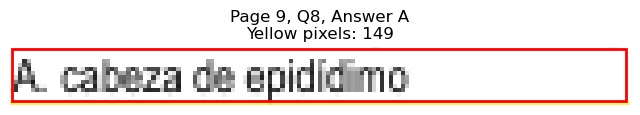

Page 9, Q8 - B: Detected box: x0=56.6, y0=493.4, x1=141.5, y1=506.0
Page 9, Q8, B: Yellow pixels: 1442
Page 9, Q8, B: Total non-white pixels: 1770
Page 9, Q8, B: Yellow percentage: 81.5%


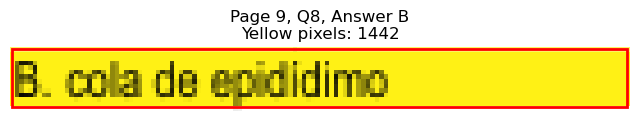

Page 9, Q8 - C: Detected box: x0=315.4, y0=480.8, x1=363.7, y1=493.4
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 221
Page 9, Q8, C: Yellow percentage: 0.0%


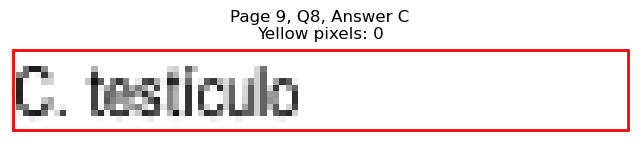

Page 9, Q8 - D: Detected box: x0=315.4, y0=493.4, x1=407.3, y1=506.0
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 452
Page 9, Q8, D: Yellow percentage: 0.0%


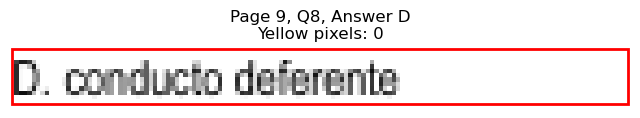


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)
Page 9, Q9 - A: Detected box: x0=56.6, y0=543.8, x1=92.4, y1=556.4
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 193
Page 9, Q9, A: Yellow percentage: 0.0%


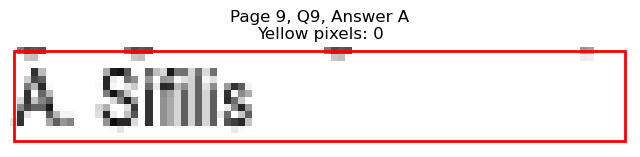

Page 9, Q9 - B: Detected box: x0=56.6, y0=556.5, x1=116.9, y1=569.1
Page 9, Q9, B: Yellow pixels: 1241
Page 9, Q9, B: Total non-white pixels: 1554
Page 9, Q9, B: Yellow percentage: 79.9%


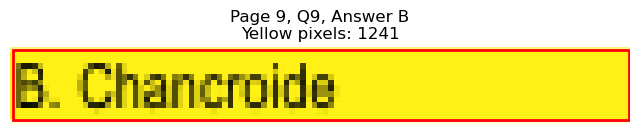

Page 9, Q9 - C: Detected box: x0=315.4, y0=543.8, x1=424.9, y1=556.4
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 523
Page 9, Q9, C: Yellow percentage: 0.0%


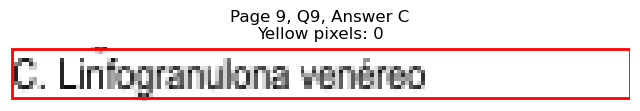

Page 9, Q9 - D: Detected box: x0=315.4, y0=556.5, x1=388.3, y1=569.1
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 369
Page 9, Q9, D: Yellow percentage: 0.0%


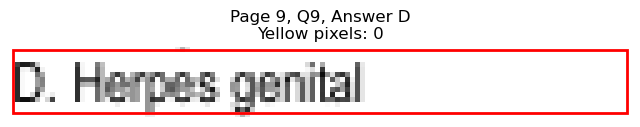


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)
Page 9, Q10 - A: Detected box: x0=56.6, y0=619.6, x1=156.6, y1=632.3
Page 9, Q10, A: Yellow pixels: 1431
Page 9, Q10, A: Total non-white pixels: 2114
Page 9, Q10, A: Yellow percentage: 67.7%


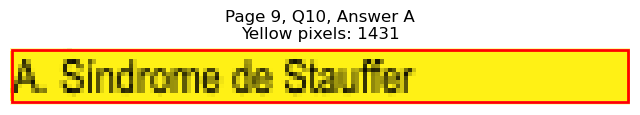

Page 9, Q10 - B: Detected box: x0=56.6, y0=632.2, x1=187.6, y1=644.9
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 817
Page 9, Q10, B: Yellow percentage: 0.0%


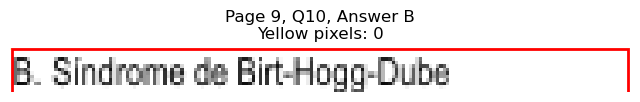

Page 9, Q10 - C: Detected box: x0=315.4, y0=619.6, x1=417.3, y1=632.3
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 484
Page 9, Q10, C: Yellow percentage: 0.0%


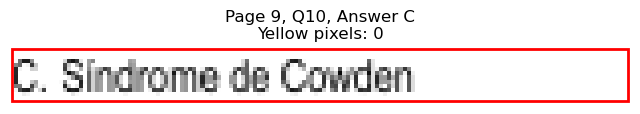

Page 9, Q10 - D: Detected box: x0=315.4, y0=632.2, x1=408.3, y1=644.9
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 433
Page 9, Q10, D: Yellow percentage: 0.0%


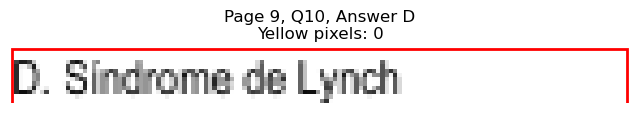


Page 9, Q10 - Selected Answer: A (based on yellow pixel count)


In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   En la Disfunción eréctil psicógena, el compone...
1   ¿Cuál de los siguientes estudios radiológicos ...
2   En pacientes en los cuales la bacteriuria no s...
3   Mujer de 65 años que acude a consulta por pérd...
4   Mujer de 22 años. Acude por lumbalgia izquierd...
..                                                ...
95  ¿Cuál de los siguientes fármacos aumenta el ri...
96  La hematuria persistente posterior a biopsia d...
97  La maduración del espermatozoide para lograr l...
98  Varón de 30 años. Hace 7 días presenta dolor i...
99  ¿Cuál es el síndrome paraneoplásico asociado a...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0       Un inicio lento y progresivo   
1   RMN multiparamétrica de próstata   
2     Prostatitis bacteriana crónica   
3                        Cistoscopía   
4        Microembolización selectiva   
..                               ...   
95                        Terazosina   
96            Fístula arterio-venosa   
97               cabeza de epidídimo   
98                           Sífilis   
99              Síndrome de Stauffer   

                                          option_B  \
0   Asociación de catecolaminas elevadas en sangre   
1                Ecografía transrectal de próstata   
2                                              HBP   
3                                       Urodinamia   
4                        Laparoscopia exploratoria   
..                                             ...   
95                                     Tamsulosina   
96                                   Rechazo agudo   
97                               cola de epidídimo   
98                                      Chancroide   
99                      Síndrome de Birt-Hogg-Dube   

                                             option_C  \
0   Tratamiento antidepresivo con inhibidores sele...   
1                                        TC de pelvis   
2                                   Estrechez uretral   
3                       Tratamiento antiincontinencia   
4                                          Lumbotomía   
..                                                ...   
95                                        Dutasteride   
96           Anastomosis urétero vesical incompetente   
97                                          testículo   
98                             Linfogranulona venéreo   
99                                 Síndrome de Cowden   

                                   option_D  
0   El tipo de pareja que tiene el paciente  
1      Ecografía de próstata transabdominal  
2                        Estenosis de meato  
3                             Láser vaginal  
4                         Vigilancia activa  
..                                      ...  
95                               Tadalafilo  
96                Pielonefritis del injerto  
97                       conducto deferente  
98                           Herpes genital  
99                        Síndrome de Lynch  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   En la Disfunción eréctil psicógena, el compone...   
1   ¿Cuál de los siguientes estudios radiológicos ...   
2   En pacientes en los cuales la bacteriuria no s...   
3   Mujer de 65 años que acude a consulta por pérd...   
4   Mujer de 22 años. Acude por lumbalgia izquierd...   
..                                                ...   
95  ¿Cuál de los siguientes fármacos aumenta el ri...   
96  La hematuria persistente posterior a biopsia d...   
97  La maduración del espermatozoide para lograr l...   
98  Varón de 30 años. Hace 7 días presenta dolor i...   
99  ¿Cuál es el síndrome paraneoplásico asociado a...   

                            option_A  \
0       Un inicio lento y progresivo   
1   RMN multiparamétrica de próstata   
2     Prostatitis bacteriana crónica   
3                        Cistoscopía   
4        Microembolización selectiva   
..                               ...   
95                        Terazosina   
96            Fístula arterio-venosa   
97               cabeza de epidídimo   
98                           Sífilis   
99              Síndrome de Stauffer   

                                          option_B  \
0   Asociación de catecolaminas elevadas en sangre   
1                Ecografía transrectal de próstata   
2                                              HBP   
3                                       Urodinamia   
4                        Laparoscopia exploratoria   
..                                             ...   
95                                     Tamsulosina   
96                                   Rechazo agudo   
97                               cola de epidídimo   
98                                      Chancroide   
99                      Síndrome de Birt-Hogg-Dube   

                                             option_C  \
0   Tratamiento antidepresivo con inhibidores sele...   
1                                        TC de pelvis   
2                                   Estrechez uretral   
3                       Tratamiento antiincontinencia   
4                                          Lumbotomía   
..                                                ...   
95                                        Dutasteride   
96           Anastomosis urétero vesical incompetente   
97                                          testículo   
98                             Linfogranulona venéreo   
99                                 Síndrome de Cowden   

                                   option_D correct_answer  
0   El tipo de pareja que tiene el paciente              B  
1      Ecografía de próstata transabdominal              B  
2                        Estenosis de meato              A  
3                             Láser vaginal              A  
4                         Vigilancia activa              D  
..                                      ...            ...  
95                               Tadalafilo              B  
96                Pielonefritis del injerto              A  
97                       conducto deferente              B  
98                           Herpes genital              B  
99                        Síndrome de Lynch              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/UROLOGÍA.csv
